<a href="https://colab.research.google.com/github/e-jungs2/DartB-25-1/blob/main/%EC%BA%90%EA%B8%80%EB%A1%9C%EB%A6%AC_3%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import collections as cl
import functools as ft
import gc
import os.path
import pprint
import time
import warnings as w

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import torch as t
import torch.nn.functional as tnf

from sklearn.model_selection import train_test_split

from IPython.display import display as ipython_display

In [9]:
def println(*args, **kwargs):
    print(*args, **kwargs)
    print("")


def pprintln(title, *args, **kwargs):
    print(f"{title}:")
    kwargs.setdefault("indent", 2)
    pprint.pp(*args, **kwargs)
    print("")

plot_layout = (1, 1)
next_subplot = 0


def plt_layout(rows, cols, figsize):
    global plot_layout, next_subplot

    plot_layout = (rows, cols)
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    fig.tight_layout()
    next_subplot = 0

    return fig


def plt_next(title):
    global plot_layout, next_subplot

    next_subplot += 1
    ax = plt.subplot(plot_layout[0], plot_layout[1], next_subplot)
    plt.title(title)

    return ax


def plt_hist(title, *args, **kwargs):
    plt_next(title)

    return plt.hist(*args, **kwargs)

def plt_scatter(t1, t2, d1, d2, *args, **kwargs):
    ax = plt_next(f"{t1} vs. {t2}")
    ax.set_xlabel(t1)
    ax.set_ylabel(t2)

    return plt.scatter(d1, d2, *args, **kwargs)


def plt_show():
    plt.show()
    next_subplot = 0


def gen_histograms_and_tables(data, columns, target_col, target_cols, with_all=True):
    target_vals = sorted(data[target_col].unique())
    need_complement = len(target_vals) > 2
    cols = len(target_vals)
    rows = 2 if need_complement else 1
    plot_height = rows * 3
    colors = [
        (0.9, 0.0, 0.0),
        (0.9, 0.7, 0.0),
        (0.0, 0.8, 0.1),
        (0.9, 0.2, 0.9),
    ]
    colors = {
        tv: color
        for tv, color in zip(target_vals, colors)
    }
    background_color = "lightgrey"
    all_color = "darkblue"
    data_grouped = {
        tv: data[data[target_col] == tv] for tv in target_vals

      }

    for col in columns:
        if col in target_cols:
            continue

        print(f"#### {col}")

        unique_vals = sorted(data[col].unique())
        hist_kwargs = {
            "bins": min(20, len(unique_vals)),
            "range": (data[col].min(), data[col].max()),
        }
        crosstab = {}
        header = [f"{col} ↓ / Target →"]
        with_crosstab = col.endswith("_cat") or col.endswith("_bin")

        if with_crosstab:
            crosstab = {v: [] for v in unique_vals}
            hist_kwargs["bins"] = len(unique_vals)

        plt_layout(rows, cols, (12, plot_height)).set_facecolor(background_color)

        for tv in target_vals:
            if with_all:
                plt_next(f"{tv} vs. all").set_facecolor(background_color)
                plt.hist(data[col], label="all", color=all_color, **hist_kwargs)
            else:
                plt_next(tv).set_facecolor(background_color)
            plt.hist(
                data_grouped[tv][col],
                label=tv,
                color=colors.get(tv, "black"),
                **hist_kwargs,
            )
            plt.legend()

            if with_crosstab:
                header.append(tv)
                add_to_crosstab(crosstab, data_grouped[tv][col], unique_vals)

        if need_complement:
            for tv in target_vals:
                plt_next(f"not {tv} vs. all").set_facecolor(background_color)
                plt.hist(data[col], label="all", color=all_color, **hist_kwargs)
                plt.hist(
                    data_grouped_inv[tv][col],
                    label=tv,
                    color=colors.get(tv, "black"),
                    **hist_kwargs,
                )
                plt.legend()

        plt_show()

        if with_crosstab:
            header.append("Total")
            add_to_crosstab(crosstab, data[col], unique_vals)
            print_crosstab(header, crosstab, col)
        else:
            print_stats(data, col, target_vals, data_grouped)

        print("")

def add_to_crosstab(crosstab, values, unique_vals):
    dist = dict(cl.Counter(values))
    perc_scale = 100.0 / len(values)

    for k in unique_vals:
        count = dist.get(k, 0)
        perc = count * perc_scale
        crosstab[k].append((count, perc))


def print_crosstab(header, crosstab, col):
    width_0 = min(45, max(45, len(header[0])))
    width = 16
    totals = [0] * (len(header) - 1)

    print(
        f"| {truncate_feature_name(header[0], width_0):{width_0}} | "
        + " | ".join(f"{c:>{width}}" for c in header[1:])
        + " |"
    )
    print(
        f"| {'-' * width_0} | "
        + " | ".join("-" * width for c in header[1:])
        + " |"
    )

    for key, row in crosstab.items():
        print(
            f"| {truncate_feature_name(str(key), width_0):{width_0}} | "
            +  " | ".join(f"{prc:>{width-1}.3f}%" for cnt, prc in row[:-1])
            + f" | {row[-1][0]:>{width}}"
            +  " |"
        )

        for i, (cnt, prc) in enumerate(row):
            totals[i] += cnt

    print(
        f"| {'-':{width_0}} | "
        + " | ".join(f"{'-':>{width}}" for c in header[1:])
        + " |"
    )
    print(
        f"| {'Total':{width_0}} | "
        + " | ".join(f"{t:>{width}}" for t in totals)
        + " |"
    )


def truncate_feature_name(text, max_len):
    if len(text) <= max_len:
        return text

    keep = (max_len - 3) // 2

    return text[:keep] + "..." + text[-keep:]

def print_stats(data, col, target_vals, data_grouped):
    width = 11
    width_0 = 32
    table = [
        [truncate_feature_name(col, width_0), "Min", "Min (!= -1)", "Max", "Mean", "Var", "Skewness", "Kurtosis"],
        ["-" * width_0] + ["-" * width] * 7,
    ]

    for t, d in [(tv, data_grouped[tv][col]) for tv in target_vals] + [(None, None), ("All", data[col])]:
        if d is None:
            table.append(["-"] * 8)
            continue

        table.append(
            [t, d.min(), d[d != -1].min(), d.max(), d.mean(), d.var() ** 0.5, d.skew(), d.kurt()]
        )

    for row in table:
        print(
            "| "
            + " | ".join(
                format_stat_cell(i, c, width_0 if i == 0 else width)
                for i, c in enumerate(row)
            )
            + " |"
        )

def format_stat_cell(i, c, width):
    if isinstance(c, str):
        return f"{c:{width}}" if i == 0 else f"{c:>{width}}"

    return f"{c:{width}.3f}" if i == 0 else f"{c:>{width}.3f}"


In [10]:
target_col = "target"
target_cols = {target_col}

data_path = "/kaggle/input/porto-seguro-safe-driver-prediction"

if not os.path.isdir(data_path):
    data_path = "/content/drive/MyDrive/다트비/캐글로리/"

In [11]:
train = pd.read_csv(os.path.join(data_path, "train.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))

rnd_subset = train[np.random.rand(len(train)) <= 0.05]

rnd_X = rnd_subset.drop(columns=["id", target_col])
rnd_y = rnd_subset[target_col]
rnd_X_train, rnd_X_test, rnd_y_train, rnd_y_test = train_test_split(
    rnd_X,
    rnd_y,
    test_size=0.2,
    random_state=4242,
    shuffle=True,
    stratify=rnd_y
)

#### train: target
                   0:    573518   (96.355%)
                   1:     21694   ( 3.645%)

#### rnd_subset: target
                   0:     28787   (96.403%)
                   1:      1074   ( 3.597%)

#### NaNs
             Feature                  Train                     Test
       ps_ind_02_cat       216 (  0.03629%)         307 (  0.03439%)
       ps_ind_04_cat        83 (  0.01394%)         145 (  0.01624%)
       ps_ind_05_cat      5809 (  0.97595%)        8710 (  0.97556%)
           ps_reg_03    107772 ( 18.10649%)      161684 ( 18.10944%)
       ps_car_01_cat       107 (  0.01798%)         160 (  0.01792%)
       ps_car_02_cat         5 (  0.00084%)           5 (  0.00056%)
       ps_car_03_cat    411231 ( 69.08984%)      616911 ( 69.09722%)
       ps_car_05_cat    266551 ( 44.78253%)      400359 ( 44.84227%)
       ps_car_07_cat     11489 (  1.93024%)       17331 (  1.94116%)
       ps_car_09_cat       569 (  0.09560%)         877 (  0.09823%)
          

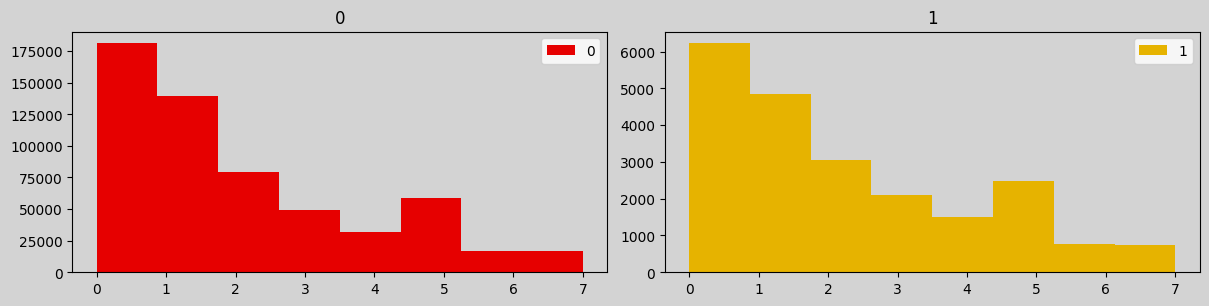

| ps_ind_01                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       7.000 |       1.893 |       1.981 |       0.938 |      -0.204 |
|                            1.000 |       0.000 |       0.000 |       7.000 |       2.090 |       2.042 |       0.768 |      -0.543 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       7.000 |       1.900 |       1.984 |       0.932 |      -0.219 |

#### ps_ind_02_cat


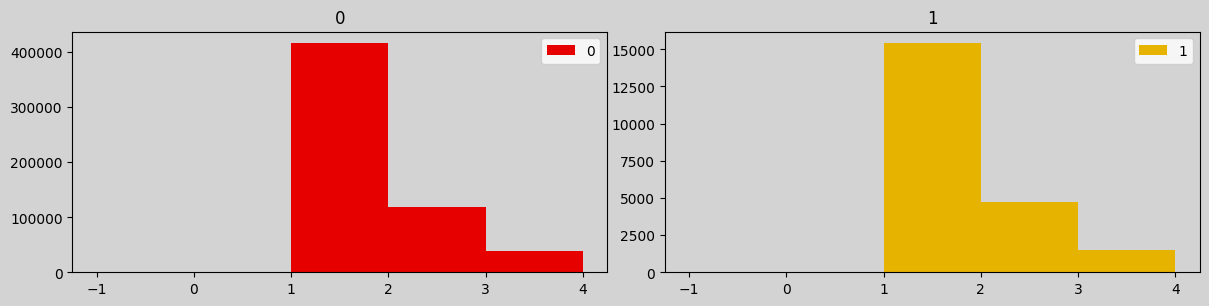

| ps_ind_02_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| -1                                            |           0.031% |           0.184% |              216 |
| 1                                             |          72.610% |          71.116% |           431859 |
| 2                                             |          20.725% |          21.725% |           123573 |
| 3                                             |           4.732% |           4.835% |            28186 |
| 4                                             |           1.903% |           2.139% |            11378 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_03


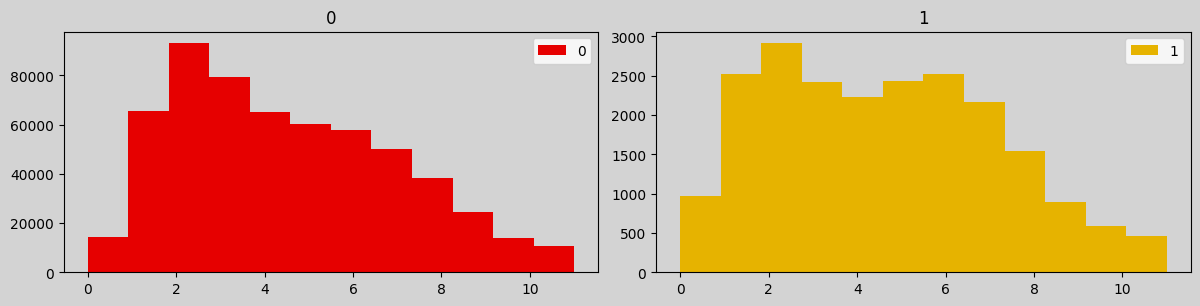

| ps_ind_03                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |      11.000 |       4.419 |       2.696 |       0.470 |      -0.645 |
|                            1.000 |       0.000 |       0.000 |      11.000 |       4.539 |       2.792 |       0.306 |      -0.770 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |      11.000 |       4.423 |       2.700 |       0.464 |      -0.650 |

#### ps_ind_04_cat


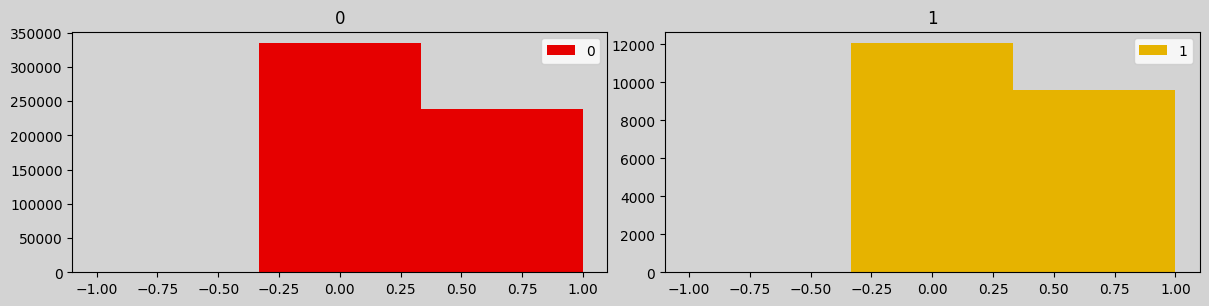

| ps_ind_04_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| -1                                            |           0.009% |           0.152% |               83 |
| 0                                             |          58.393% |          55.642% |           346965 |
| 1                                             |          41.598% |          44.206% |           248164 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_05_cat


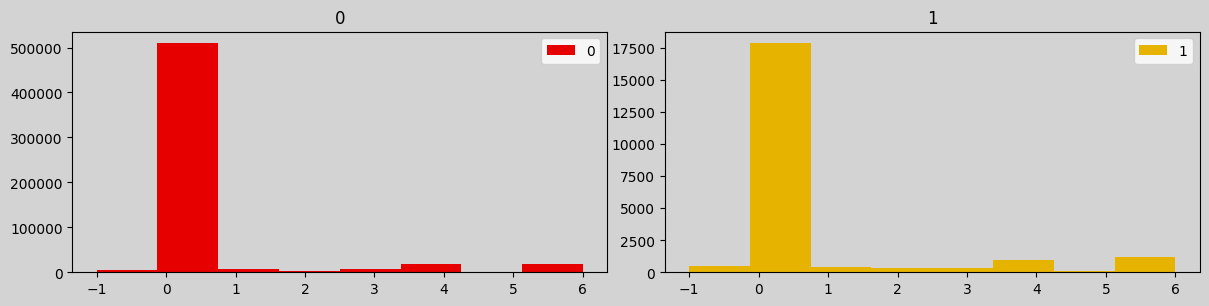

| ps_ind_05_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| -1                                            |           0.928% |           2.231% |             5809 |
| 0                                             |          88.947% |          82.424% |           528009 |
| 1                                             |           1.382% |           1.835% |             8322 |
| 2                                             |           0.674% |           1.457% |             4184 |
| 3                                             |           1.374% |           1.632% |             8233 |
| 4                                             |           3.032% |           4.402% |            18344 |
| 5                                             |           0.274% |           0.369% |             1649 |
| 6                                  

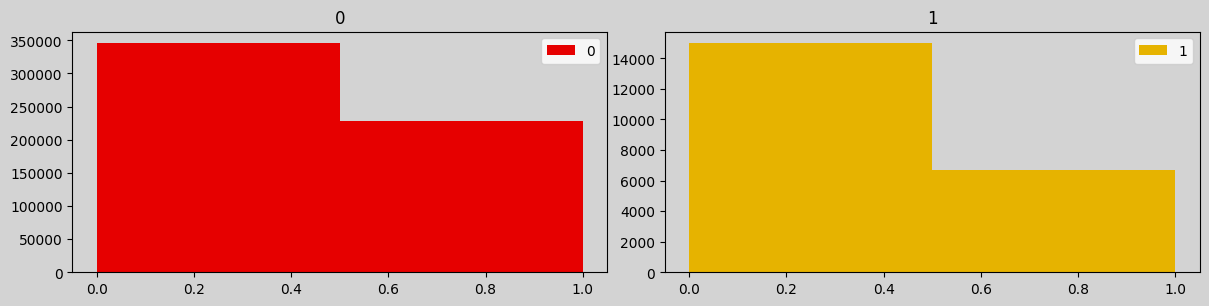

| ps_ind_06_bin ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          60.303% |          69.171% |           360852 |
| 1                                             |          39.697% |          30.829% |           234360 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_07_bin


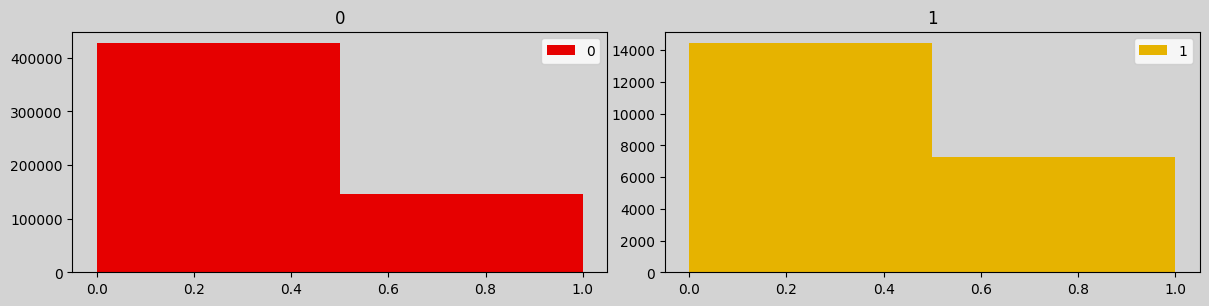

| ps_ind_07_bin ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          74.588% |          66.608% |           442223 |
| 1                                             |          25.412% |          33.392% |           152989 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_08_bin


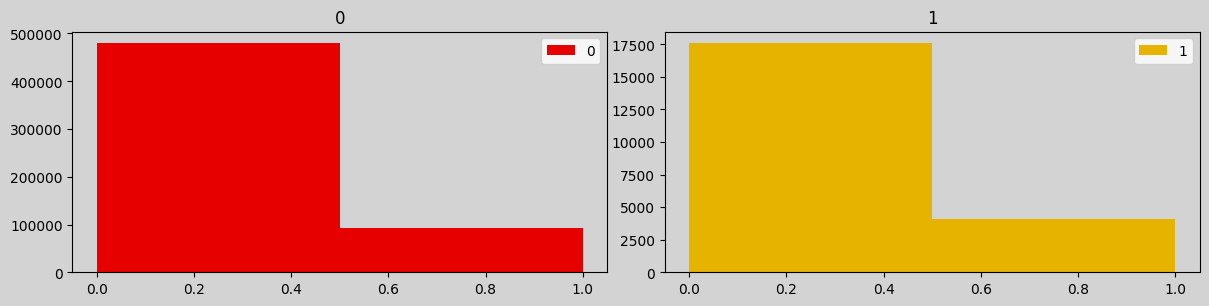

| ps_ind_08_bin ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          83.703% |          81.105% |           497644 |
| 1                                             |          16.297% |          18.895% |            97568 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_09_bin


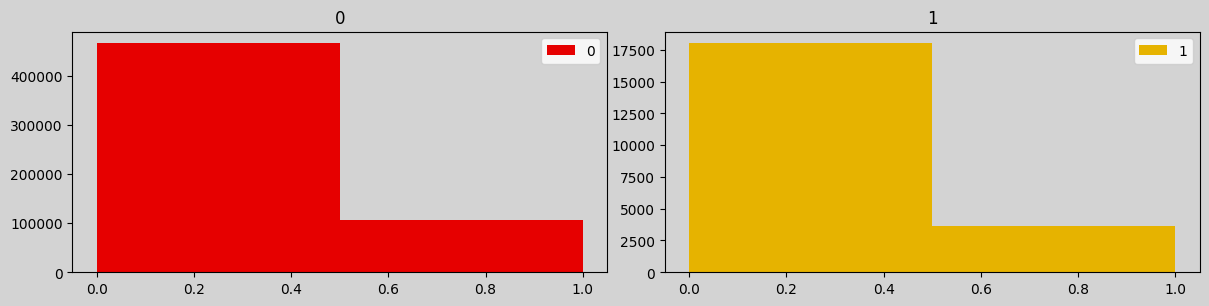

| ps_ind_09_bin ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          81.407% |          83.115% |           484917 |
| 1                                             |          18.593% |          16.885% |           110295 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_10_bin


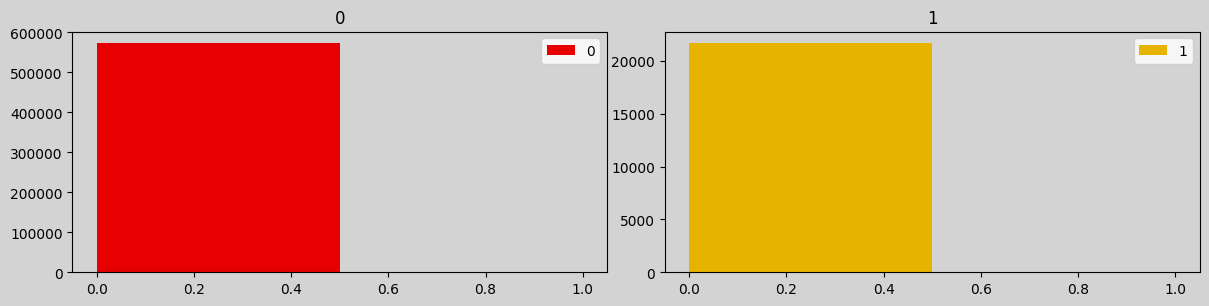

| ps_ind_10_bin ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          99.963% |          99.945% |           594990 |
| 1                                             |           0.037% |           0.055% |              222 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_11_bin


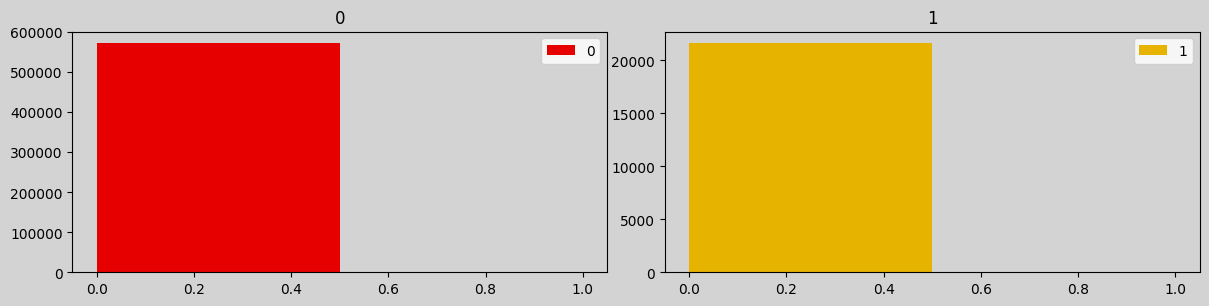

| ps_ind_11_bin ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          99.832% |          99.788% |           594205 |
| 1                                             |           0.168% |           0.212% |             1007 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_12_bin


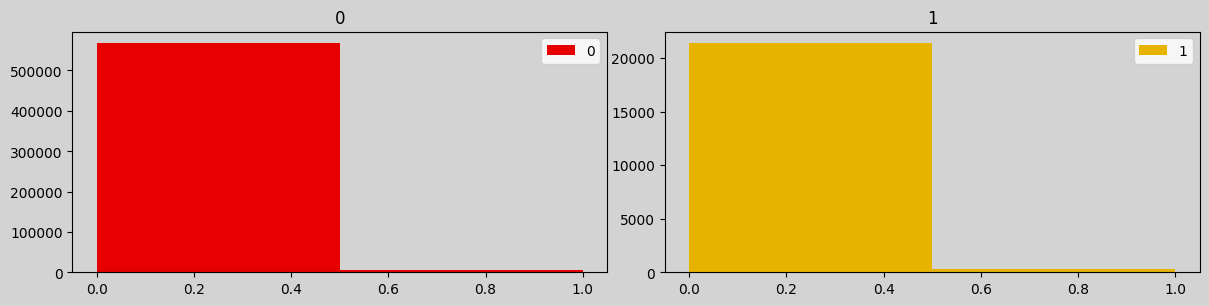

| ps_ind_12_bin ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          99.071% |          98.668% |           589594 |
| 1                                             |           0.929% |           1.332% |             5618 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_13_bin


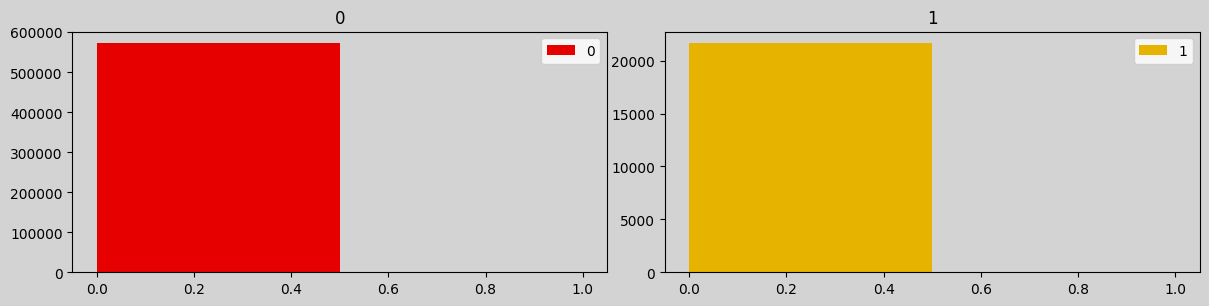

| ps_ind_13_bin ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          99.907% |          99.866% |           594648 |
| 1                                             |           0.093% |           0.134% |              564 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_14


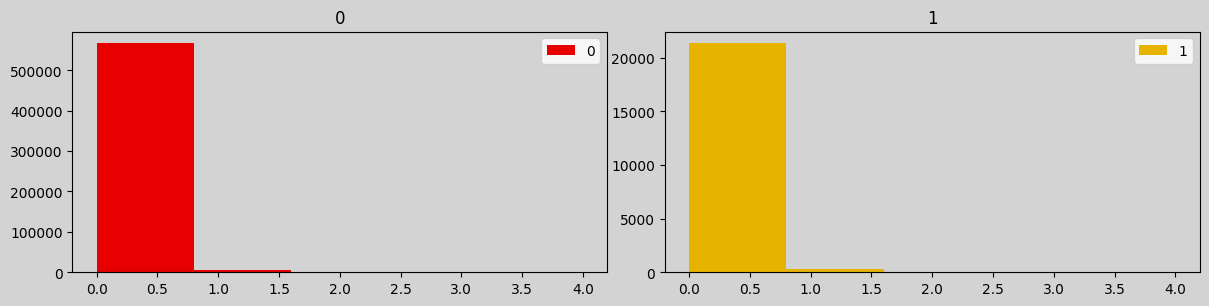

| ps_ind_14                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       4.000 |       0.012 |       0.126 |      12.265 |     182.015 |
|                            1.000 |       0.000 |       0.000 |       4.000 |       0.017 |       0.153 |      10.842 |     146.531 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       4.000 |       0.012 |       0.128 |      12.208 |     180.698 |

#### ps_ind_15


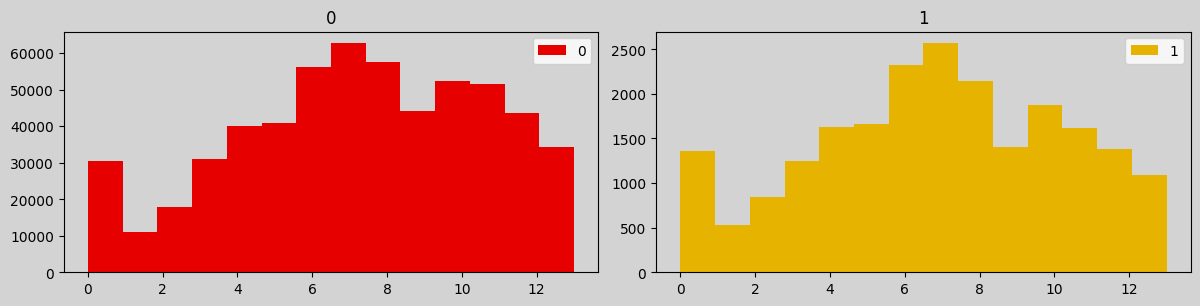

| ps_ind_15                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |      13.000 |       7.315 |       3.545 |      -0.290 |      -0.733 |
|                            1.000 |       0.000 |       0.000 |      13.000 |       6.908 |       3.558 |      -0.180 |      -0.771 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |      13.000 |       7.300 |       3.546 |      -0.286 |      -0.736 |

#### ps_ind_16_bin


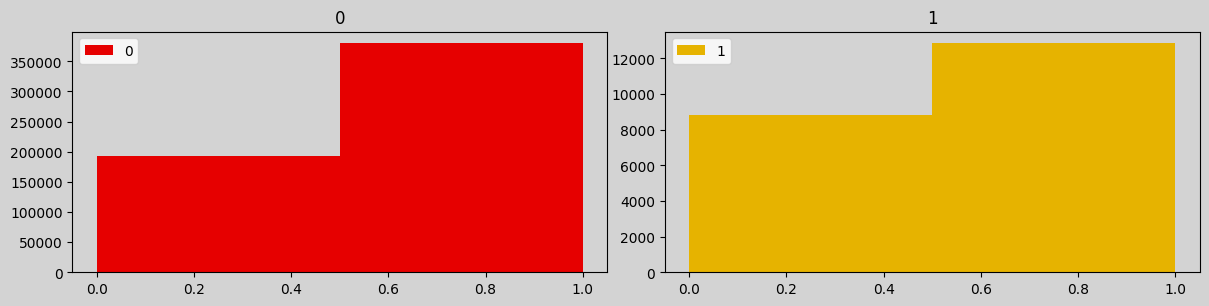

| ps_ind_16_bin ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          33.662% |          40.679% |           201882 |
| 1                                             |          66.338% |          59.321% |           393330 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_17_bin


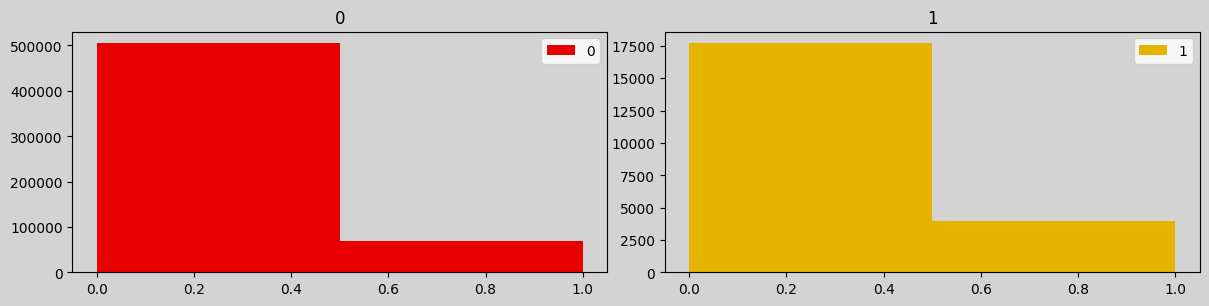

| ps_ind_17_bin ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          88.127% |          81.677% |           523143 |
| 1                                             |          11.873% |          18.323% |            72069 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_ind_18_bin


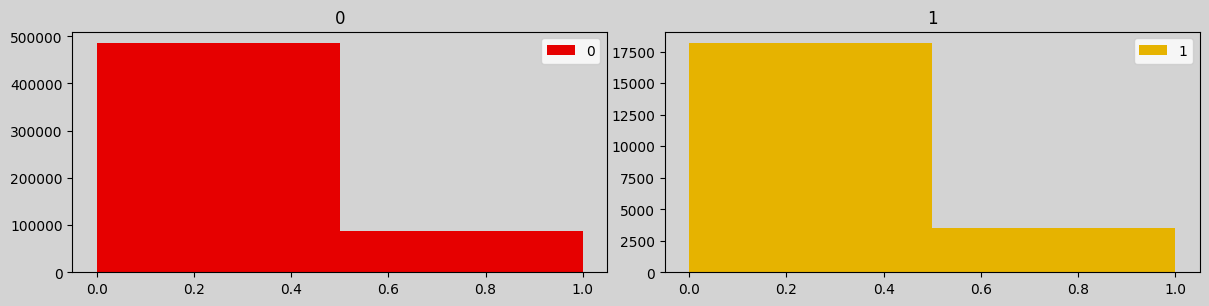

| ps_ind_18_bin ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          84.687% |          83.811% |           503879 |
| 1                                             |          15.313% |          16.189% |            91333 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_reg_01


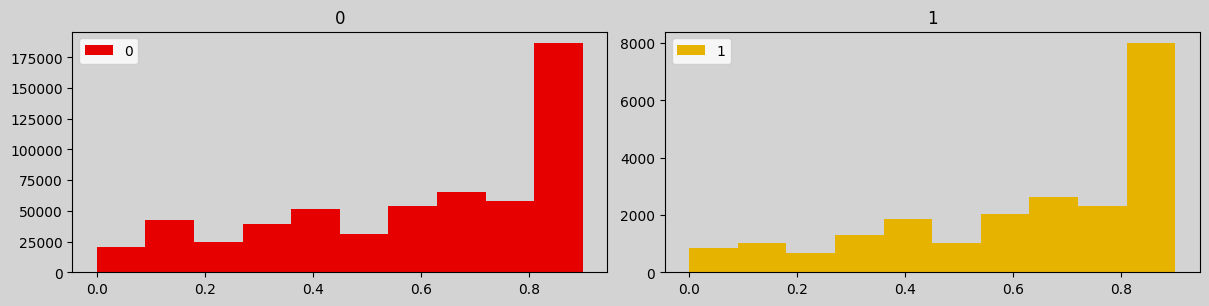

| ps_reg_01                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       0.900 |       0.610 |       0.288 |      -0.632 |      -0.899 |
|                            1.000 |       0.000 |       0.000 |       0.900 |       0.645 |       0.277 |      -0.855 |      -0.467 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       0.900 |       0.611 |       0.288 |      -0.639 |      -0.887 |

#### ps_reg_02


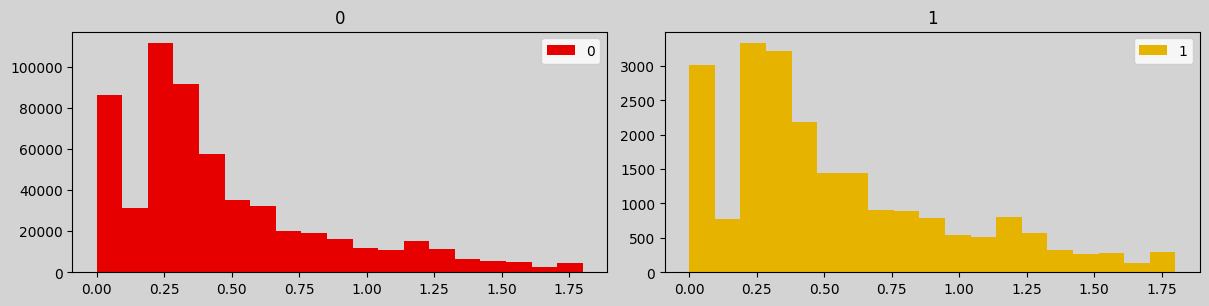

| ps_reg_02                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       1.800 |       0.436 |       0.403 |       1.291 |       1.162 |
|                            1.000 |       0.000 |       0.000 |       1.800 |       0.512 |       0.442 |       1.024 |       0.314 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       1.800 |       0.439 |       0.404 |       1.281 |       1.124 |

#### ps_reg_03


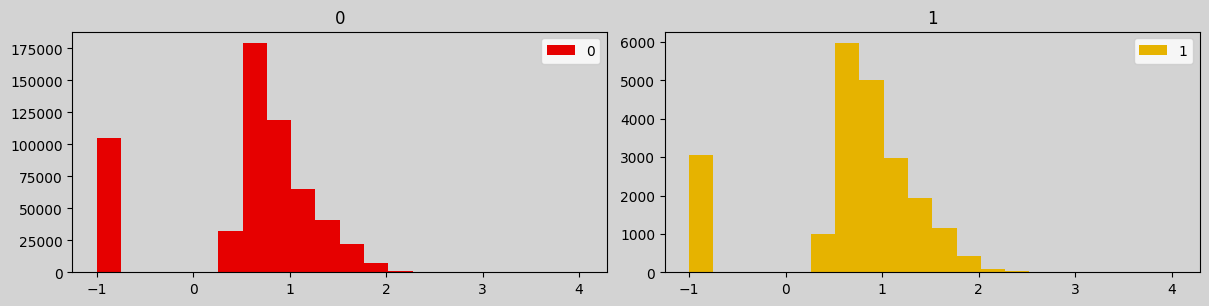

| ps_reg_03                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |      -1.000 |       0.061 |       4.038 |       0.546 |       0.794 |      -1.007 |       0.062 |
|                            1.000 |      -1.000 |       0.254 |       3.198 |       0.677 |       0.758 |      -1.184 |       0.832 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |      -1.000 |       0.061 |       4.038 |       0.551 |       0.794 |      -1.013 |       0.086 |

#### ps_car_01_cat


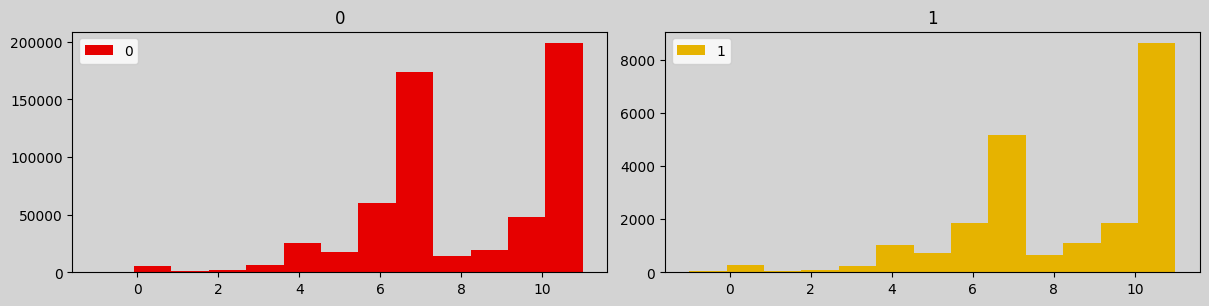

| ps_car_01_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| -1                                            |           0.013% |           0.157% |              107 |
| 0                                             |           0.984% |           1.194% |             5904 |
| 1                                             |           0.227% |           0.295% |             1367 |
| 2                                             |           0.358% |           0.424% |             2144 |
| 3                                             |           1.117% |           1.152% |             6658 |
| 4                                             |           4.385% |           4.725% |            26174 |
| 5                                             |           3.039% |           3.282% |            18142 |
| 6                                  

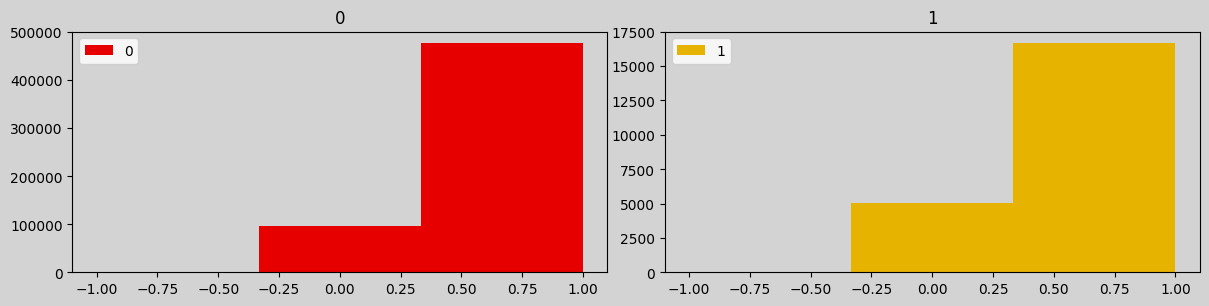

| ps_car_02_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| -1                                            |           0.001% |           0.000% |                5 |
| 0                                             |          16.775% |          23.099% |           101217 |
| 1                                             |          83.224% |          76.901% |           493990 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_car_03_cat


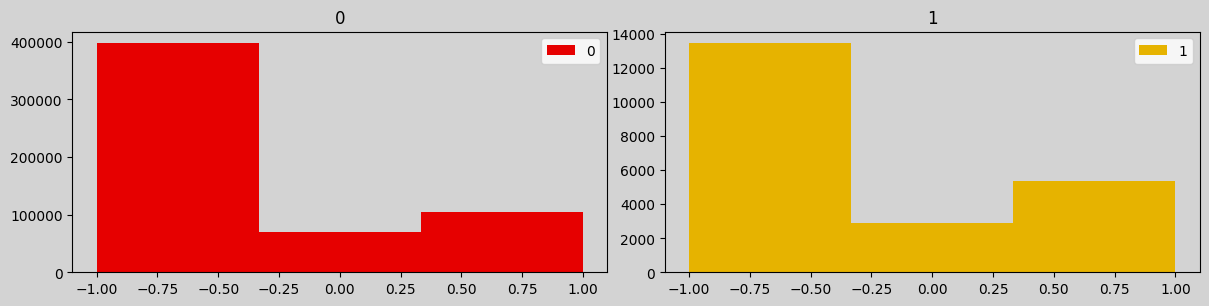

| ps_car_03_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| -1                                            |          69.358% |          61.999% |           411231 |
| 0                                             |          12.271% |          13.354% |            73272 |
| 1                                             |          18.371% |          24.647% |           110709 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_car_04_cat


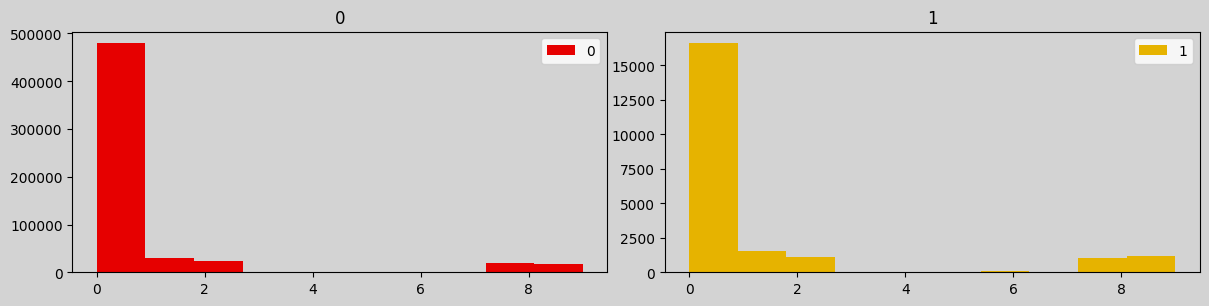

| ps_car_04_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          83.689% |          76.570% |           496581 |
| 1                                             |           5.326% |           7.228% |            32115 |
| 2                                             |           3.949% |           5.172% |            23770 |
| 3                                             |           0.106% |           0.152% |              640 |
| 4                                             |           0.039% |           0.023% |              230 |
| 5                                             |           0.088% |           0.180% |              545 |
| 6                                             |           0.256% |           0.424% |             1560 |
| 7                                  

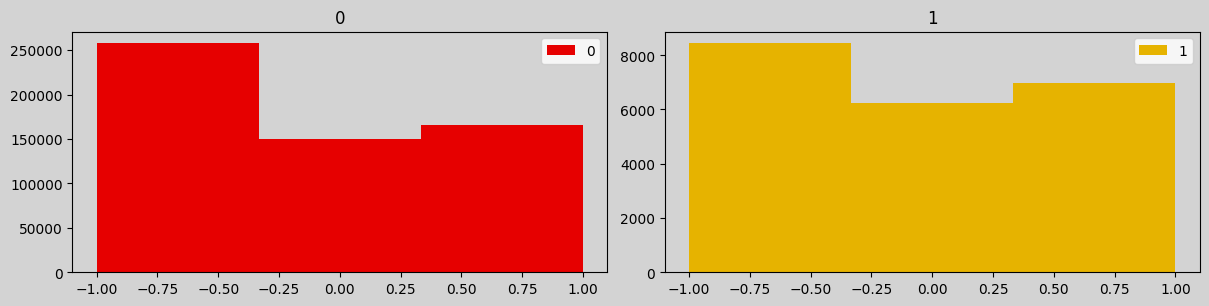

| ps_car_05_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| -1                                            |          45.003% |          38.960% |           266551 |
| 0                                             |          26.109% |          28.842% |           155994 |
| 1                                             |          28.889% |          32.198% |           172667 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_car_06_cat


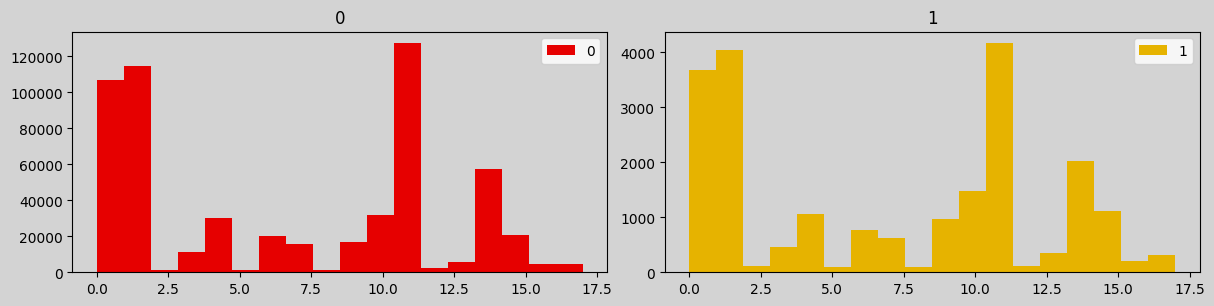

| ps_car_06_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          18.611% |          16.986% |           110420 |
| 1                                             |          19.936% |          18.655% |           118386 |
| 2                                             |           0.262% |           0.489% |             1607 |
| 3                                             |           2.012% |           2.111% |            11997 |
| 4                                             |           5.245% |           4.858% |            31136 |
| 5                                             |           0.228% |           0.433% |             1401 |
| 6                                             |           3.519% |           3.554% |            20951 |
| 7                                  

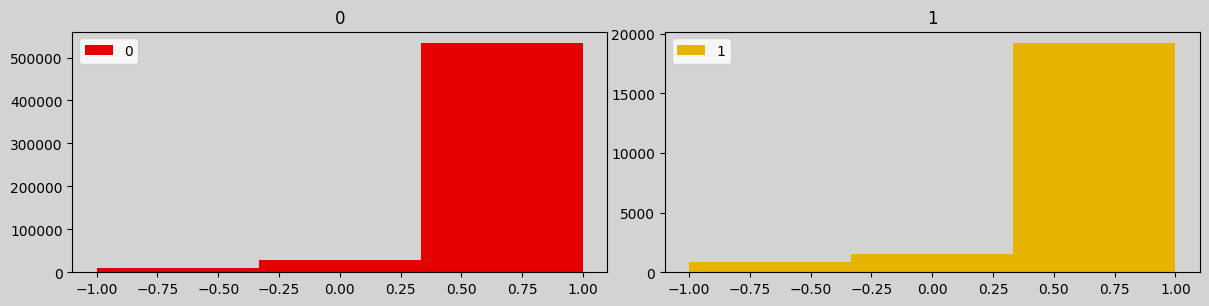

| ps_car_07_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| -1                                            |           1.847% |           4.139% |            11489 |
| 0                                             |           5.058% |           7.214% |            30575 |
| 1                                             |          93.095% |          88.647% |           553148 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_car_08_cat


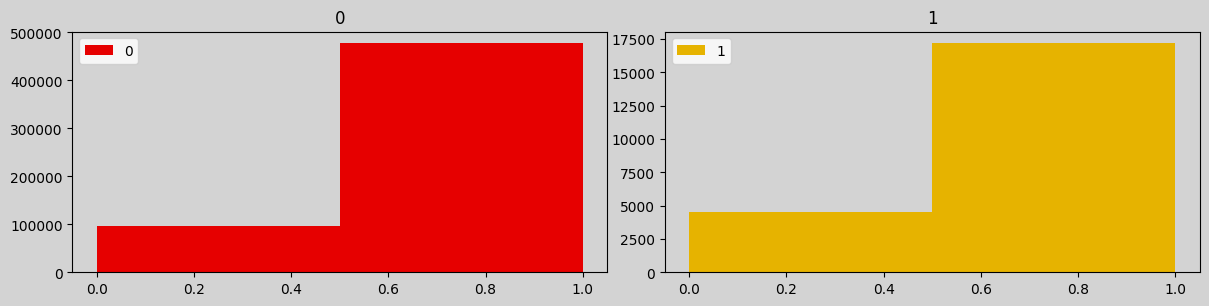

| ps_car_08_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          16.644% |          20.702% |            99948 |
| 1                                             |          83.356% |          79.298% |           495264 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_car_09_cat


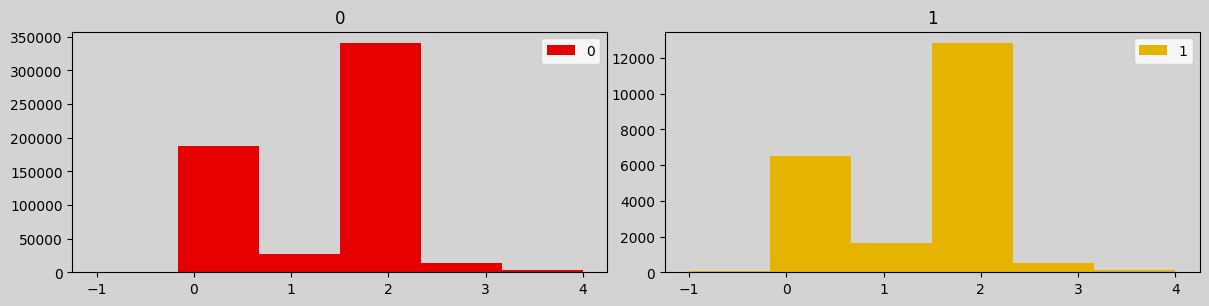

| ps_car_09_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| -1                                            |           0.090% |           0.240% |              569 |
| 0                                             |          32.786% |          29.898% |           194518 |
| 1                                             |           4.782% |           7.633% |            29080 |
| 2                                             |          59.396% |          59.178% |           353482 |
| 3                                             |           2.483% |           2.388% |            14756 |
| 4                                             |           0.464% |           0.664% |             2807 |
| -                                             |                - |                - |                - |
| Total                              

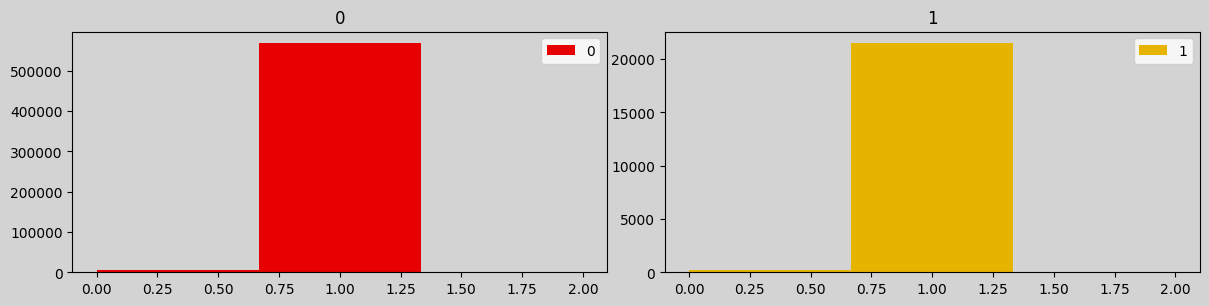

| ps_car_10_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |           0.818% |           0.770% |             4857 |
| 1                                             |          99.153% |          99.198% |           590179 |
| 2                                             |           0.029% |           0.032% |              176 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_car_11_cat


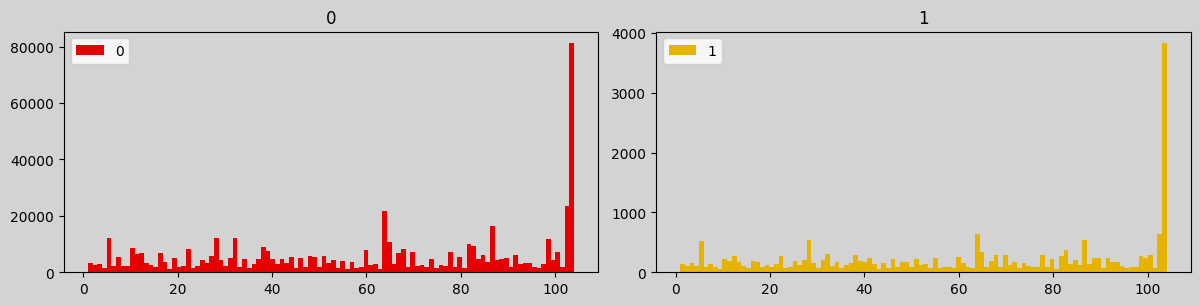

| ps_car_11_cat ↓ / Target →                    |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 1                                             |           0.557% |           0.622% |             3331 |
| 2                                             |           0.428% |           0.447% |             2553 |
| 3                                             |           0.527% |           0.751% |             3185 |
| 4                                             |           0.261% |           0.447% |             1596 |
| 5                                             |           2.090% |           2.420% |            12513 |
| 6                                             |           0.416% |           0.424% |             2480 |
| 7                                             |           0.961% |           0.664% |             5653 |
| 8                                  

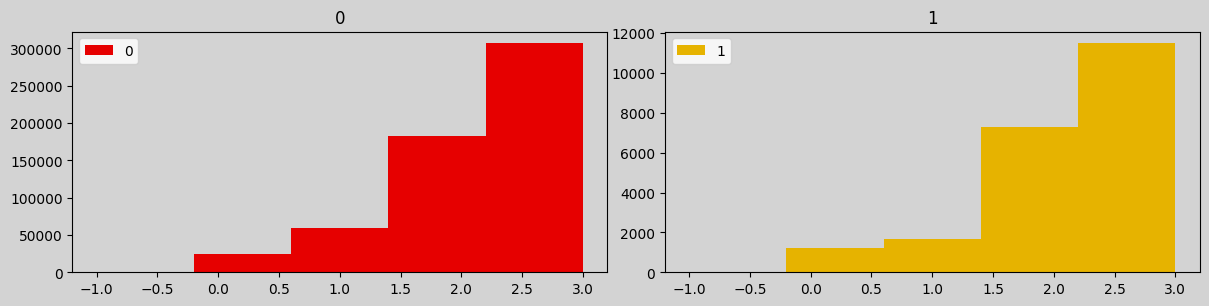

| ps_car_11                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |      -1.000 |       0.000 |       3.000 |       2.346 |       0.832 |      -1.170 |       0.655 |
|                            1.000 |       0.000 |       0.000 |       3.000 |       2.341 |       0.846 |      -1.270 |       0.988 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |      -1.000 |       0.000 |       3.000 |       2.346 |       0.833 |      -1.173 |       0.668 |

#### ps_car_12


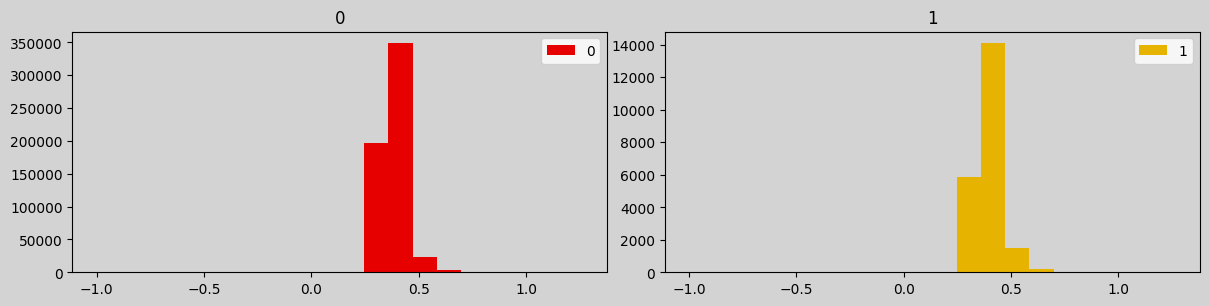

| ps_car_12                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |      -1.000 |       0.100 |       1.265 |       0.380 |       0.058 |       1.059 |       5.496 |
|                            1.000 |       0.141 |       0.141 |       1.265 |       0.392 |       0.063 |       1.181 |       5.277 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |      -1.000 |       0.100 |       1.265 |       0.380 |       0.058 |       1.067 |       5.495 |

#### ps_car_13


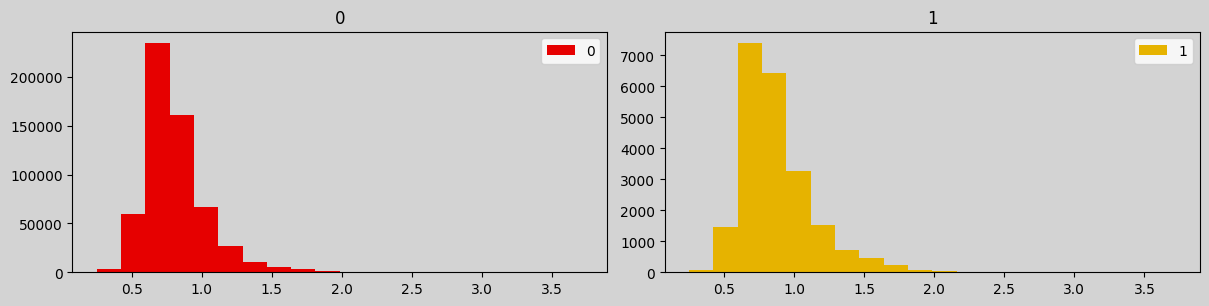

| ps_car_13                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.251 |       0.251 |       3.516 |       0.811 |       0.223 |       1.693 |       5.386 |
|                            1.000 |       0.322 |       0.322 |       3.721 |       0.876 |       0.262 |       1.691 |       5.061 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.251 |       0.251 |       3.721 |       0.813 |       0.225 |       1.701 |       5.422 |

#### ps_car_14


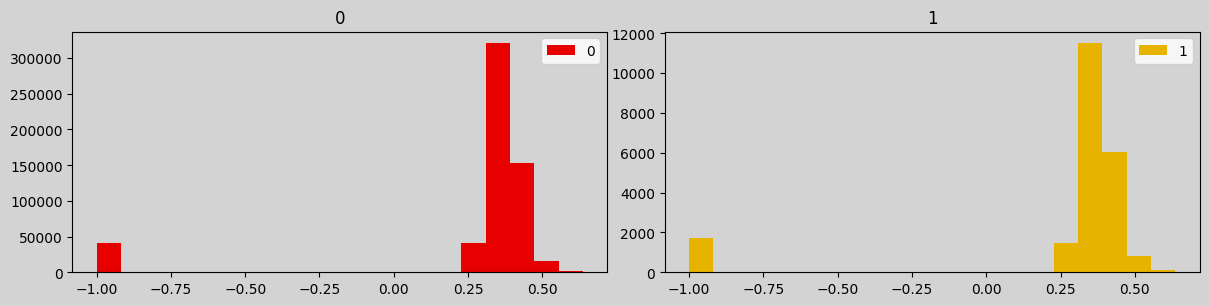

| ps_car_14                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |      -1.000 |       0.110 |       0.636 |       0.277 |       0.356 |      -3.243 |       8.748 |
|                            1.000 |      -1.000 |       0.118 |       0.632 |       0.268 |       0.376 |      -3.018 |       7.341 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |      -1.000 |       0.110 |       0.636 |       0.276 |       0.357 |      -3.234 |       8.690 |

#### ps_car_15


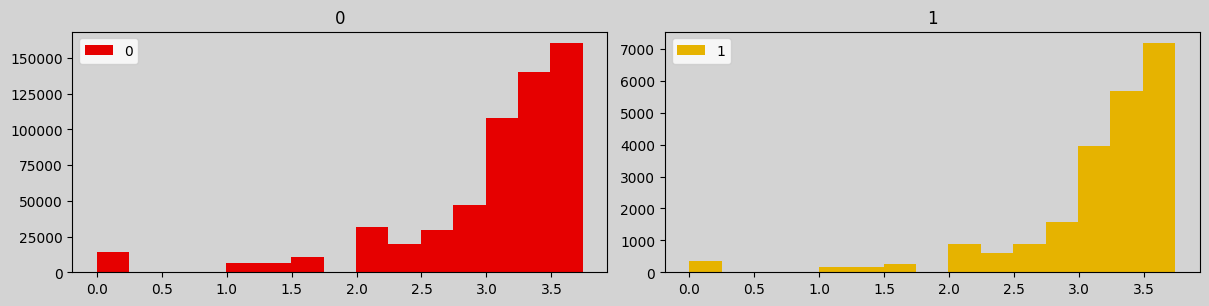

| ps_car_15                        |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       3.742 |       3.062 |       0.734 |      -2.205 |       5.799 |
|                            1.000 |       0.000 |       0.000 |       3.742 |       3.170 |       0.643 |      -2.551 |       8.502 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       3.742 |       3.066 |       0.731 |      -2.216 |       5.876 |

#### ps_calc_01


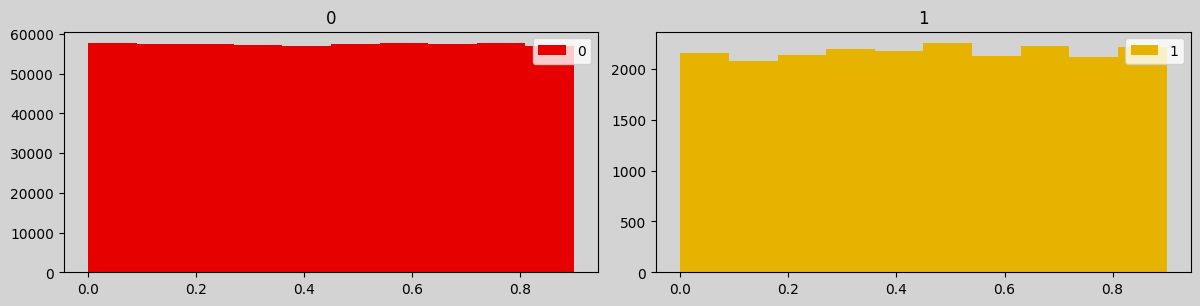

| ps_calc_01                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       0.900 |       0.450 |       0.287 |      -0.001 |      -1.225 |
|                            1.000 |       0.000 |       0.000 |       0.900 |       0.452 |       0.287 |      -0.010 |      -1.211 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       0.900 |       0.450 |       0.287 |      -0.001 |      -1.225 |

#### ps_calc_02


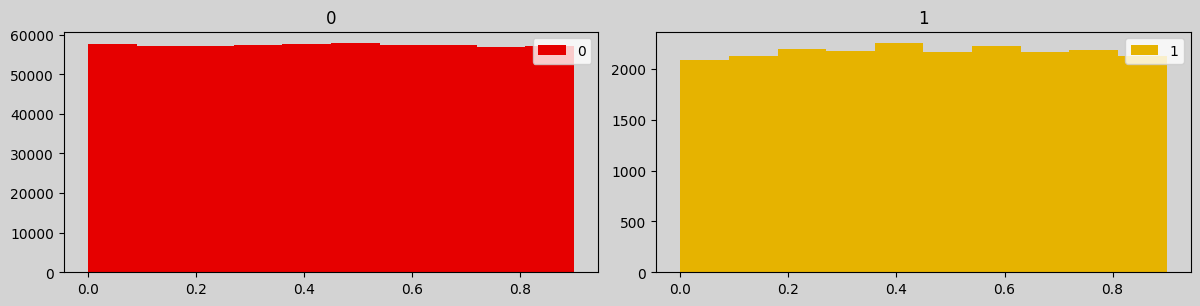

| ps_calc_02                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       0.900 |       0.450 |       0.287 |       0.001 |      -1.221 |
|                            1.000 |       0.000 |       0.000 |       0.900 |       0.452 |       0.285 |      -0.005 |      -1.209 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       0.900 |       0.450 |       0.287 |       0.001 |      -1.220 |

#### ps_calc_03


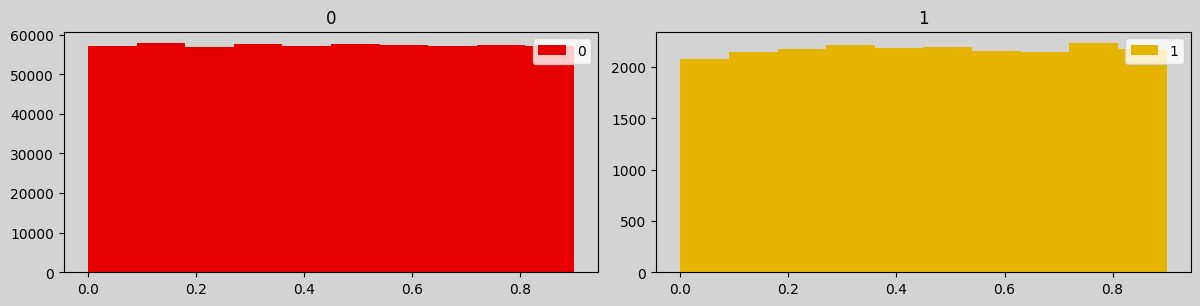

| ps_calc_03                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       0.900 |       0.450 |       0.287 |       0.001 |      -1.224 |
|                            1.000 |       0.000 |       0.000 |       0.900 |       0.453 |       0.286 |      -0.005 |      -1.218 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       0.900 |       0.450 |       0.287 |       0.001 |      -1.224 |

#### ps_calc_04


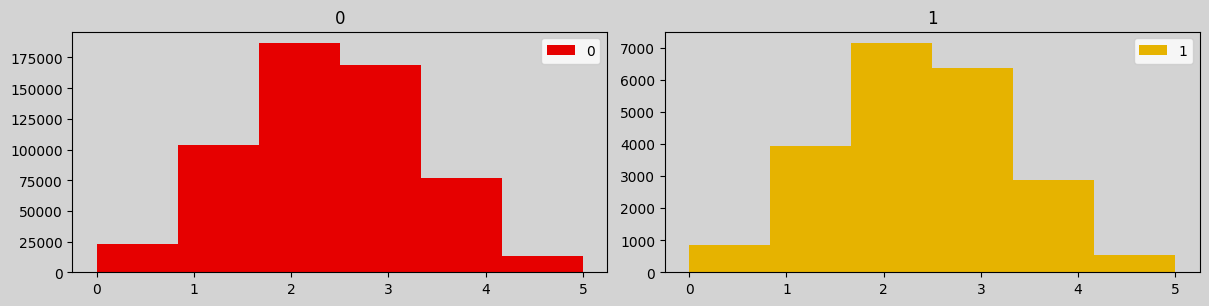

| ps_calc_04                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       5.000 |       2.372 |       1.117 |       0.043 |      -0.405 |
|                            1.000 |       0.000 |       0.000 |       5.000 |       2.372 |       1.116 |       0.060 |      -0.386 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       5.000 |       2.372 |       1.117 |       0.044 |      -0.404 |

#### ps_calc_05


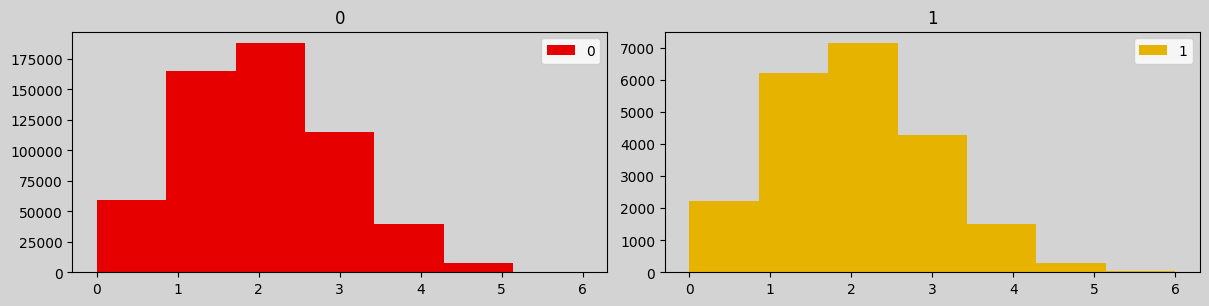

| ps_calc_05                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       6.000 |       1.886 |       1.135 |       0.328 |      -0.223 |
|                            1.000 |       0.000 |       0.000 |       6.000 |       1.890 |       1.140 |       0.354 |      -0.158 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       6.000 |       1.886 |       1.135 |       0.329 |      -0.221 |

#### ps_calc_06


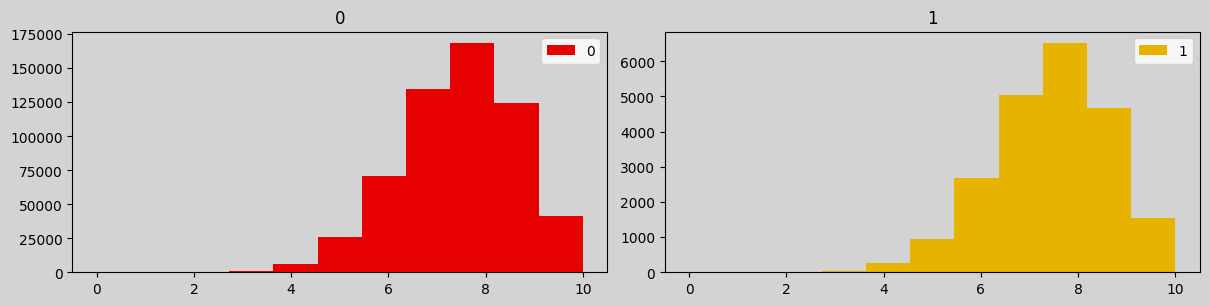

| ps_calc_06                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |      10.000 |       7.689 |       1.335 |      -0.408 |      -0.027 |
|                            1.000 |       2.000 |       2.000 |      10.000 |       7.690 |       1.328 |      -0.410 |      -0.038 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |      10.000 |       7.689 |       1.334 |      -0.408 |      -0.027 |

#### ps_calc_07


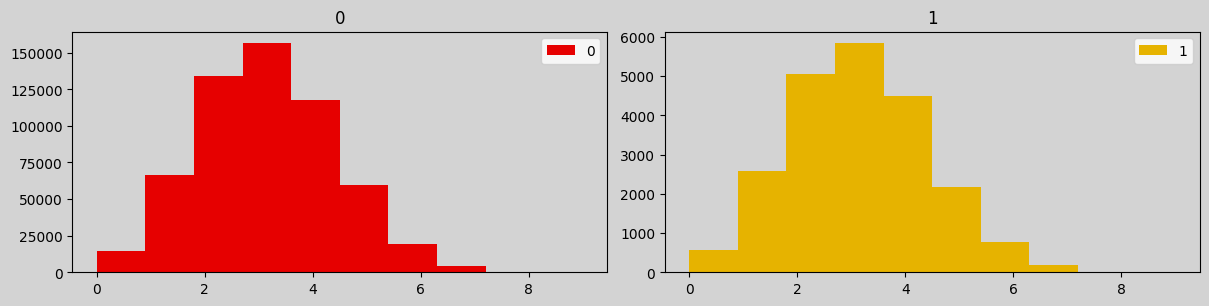

| ps_calc_07                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       9.000 |       3.006 |       1.414 |       0.233 |      -0.175 |
|                            1.000 |       0.000 |       0.000 |       9.000 |       3.005 |       1.424 |       0.249 |      -0.166 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       9.000 |       3.006 |       1.415 |       0.233 |      -0.175 |

#### ps_calc_08


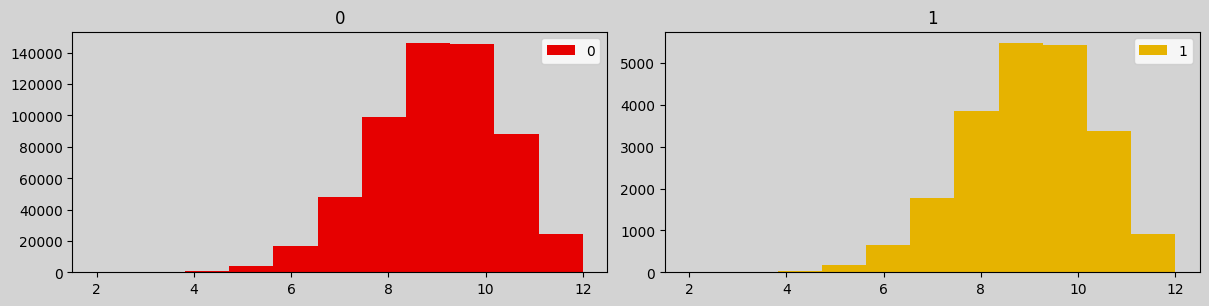

| ps_calc_08                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       2.000 |       2.000 |      12.000 |       9.226 |       1.460 |      -0.364 |      -0.041 |
|                            1.000 |       3.000 |       3.000 |      12.000 |       9.218 |       1.464 |      -0.358 |      -0.068 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       2.000 |       2.000 |      12.000 |       9.226 |       1.460 |      -0.364 |      -0.042 |

#### ps_calc_09


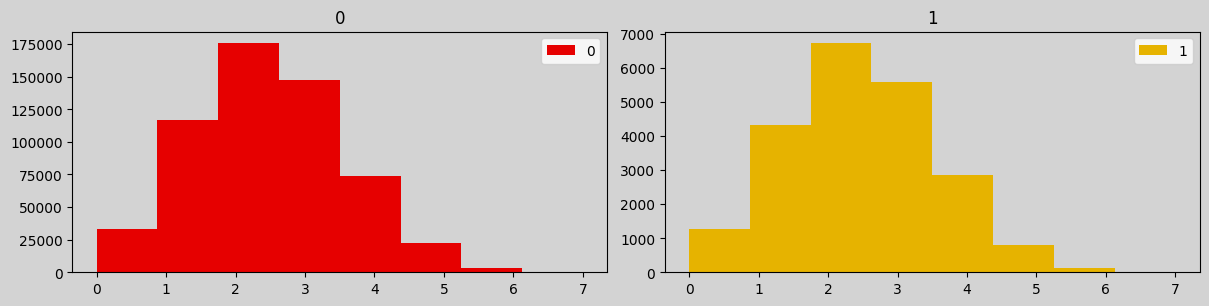

| ps_calc_09                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |       7.000 |       2.339 |       1.247 |       0.262 |      -0.224 |
|                            1.000 |       0.000 |       0.000 |       7.000 |       2.344 |       1.243 |       0.246 |      -0.216 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |       7.000 |       2.339 |       1.247 |       0.262 |      -0.224 |

#### ps_calc_10


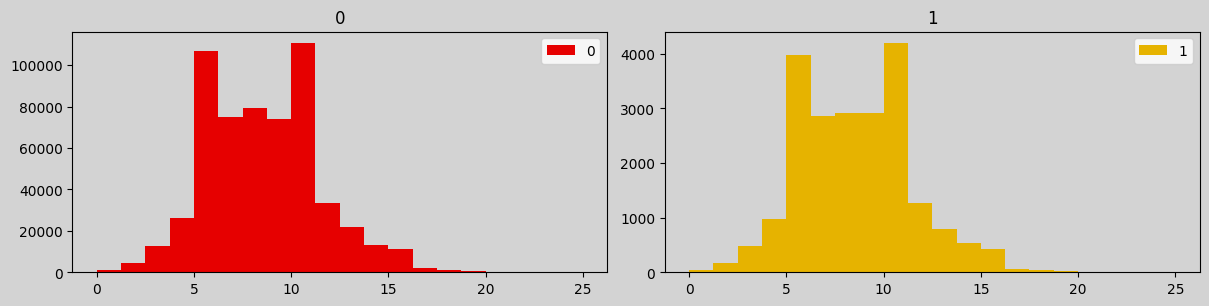

| ps_calc_10                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |      25.000 |       8.433 |       2.905 |       0.343 |       0.110 |
|                            1.000 |       0.000 |       0.000 |      22.000 |       8.449 |       2.900 |       0.347 |       0.144 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |      25.000 |       8.434 |       2.905 |       0.343 |       0.111 |

#### ps_calc_11


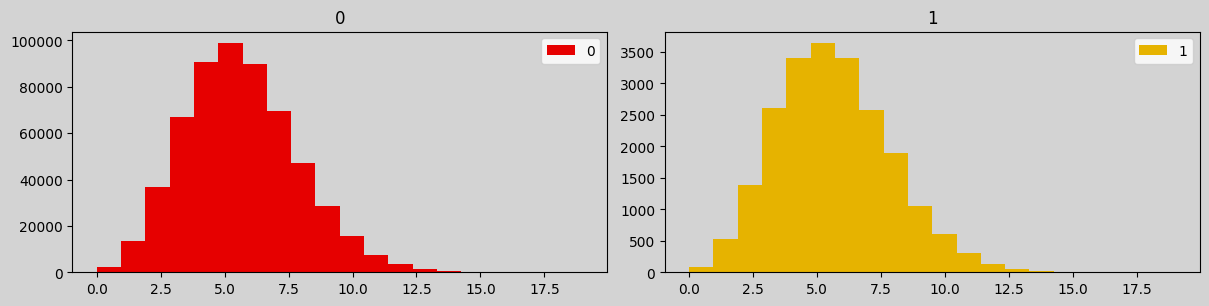

| ps_calc_11                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |      19.000 |       5.441 |       2.332 |       0.431 |       0.181 |
|                            1.000 |       0.000 |       0.000 |      16.000 |       5.446 |       2.352 |       0.430 |       0.140 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |      19.000 |       5.441 |       2.333 |       0.431 |       0.180 |

#### ps_calc_12


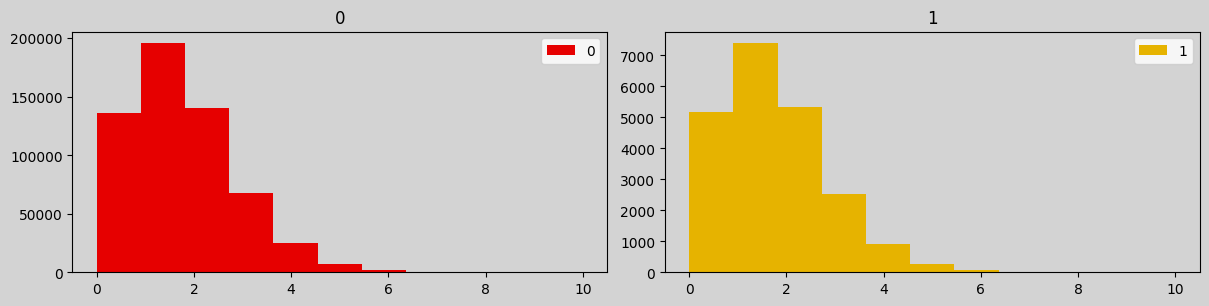

| ps_calc_12                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |      10.000 |       1.442 |       1.203 |       0.836 |       0.696 |
|                            1.000 |       0.000 |       0.000 |       8.000 |       1.435 |       1.200 |       0.836 |       0.672 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |      10.000 |       1.442 |       1.203 |       0.836 |       0.695 |

#### ps_calc_13


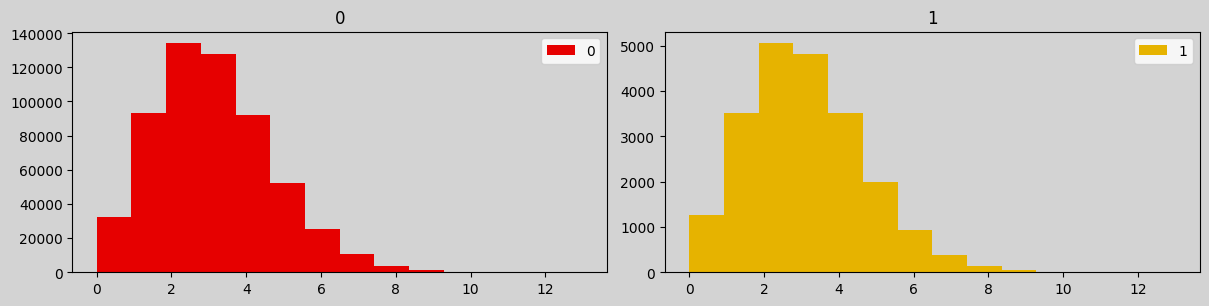

| ps_calc_13                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |      13.000 |       2.872 |       1.695 |       0.588 |       0.326 |
|                            1.000 |       0.000 |       0.000 |      13.000 |       2.868 |       1.694 |       0.579 |       0.336 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |      13.000 |       2.872 |       1.695 |       0.587 |       0.326 |

#### ps_calc_14


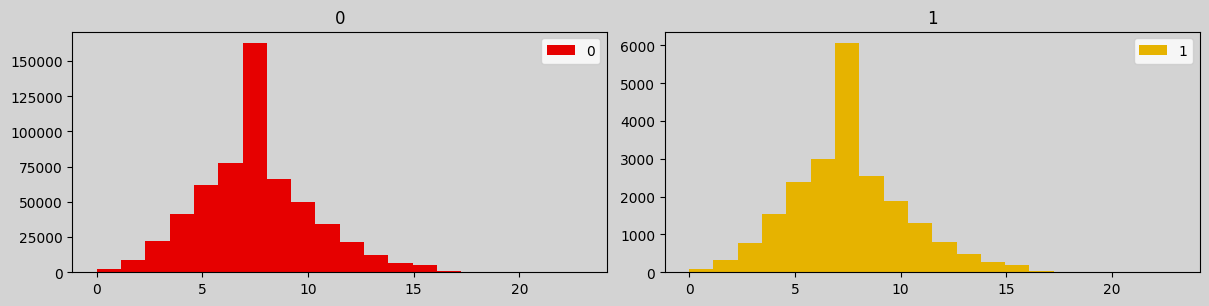

| ps_calc_14                       |         Min | Min (!= -1) |         Max |        Mean |         Var |    Skewness |    Kurtosis |
| -------------------------------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|                            0.000 |       0.000 |       0.000 |      23.000 |       7.538 |       2.746 |       0.364 |       0.136 |
|                            1.000 |       0.000 |       0.000 |      20.000 |       7.558 |       2.752 |       0.380 |       0.132 |
| -                                |           - |           - |           - |           - |           - |           - |           - |
| All                              |       0.000 |       0.000 |      23.000 |       7.539 |       2.747 |       0.365 |       0.136 |

#### ps_calc_15_bin


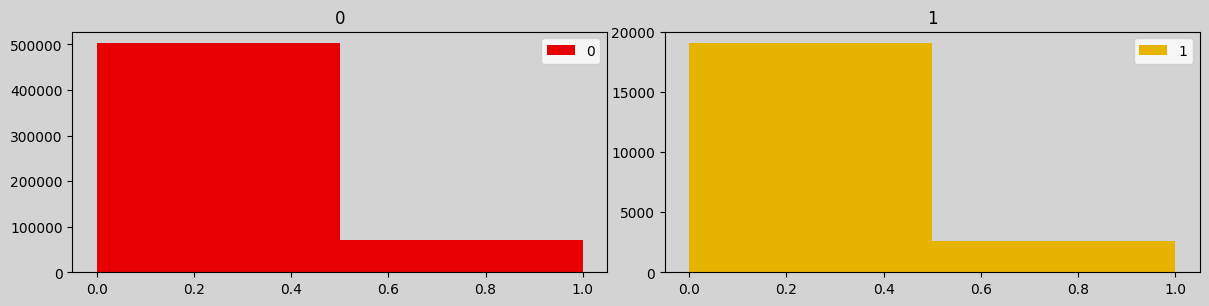

| ps_calc_15_bin ↓ / Target →                   |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          87.754% |          87.840% |           522342 |
| 1                                             |          12.246% |          12.160% |            72870 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_calc_16_bin


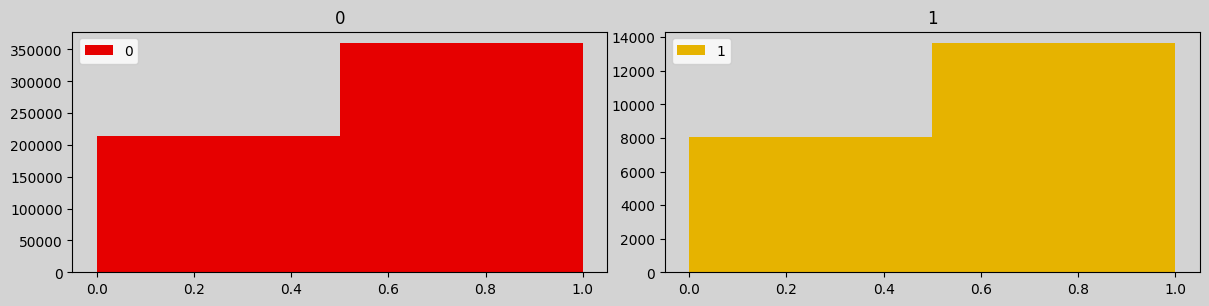

| ps_calc_16_bin ↓ / Target →                   |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          37.222% |          37.061% |           221514 |
| 1                                             |          62.778% |          62.939% |           373698 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_calc_17_bin


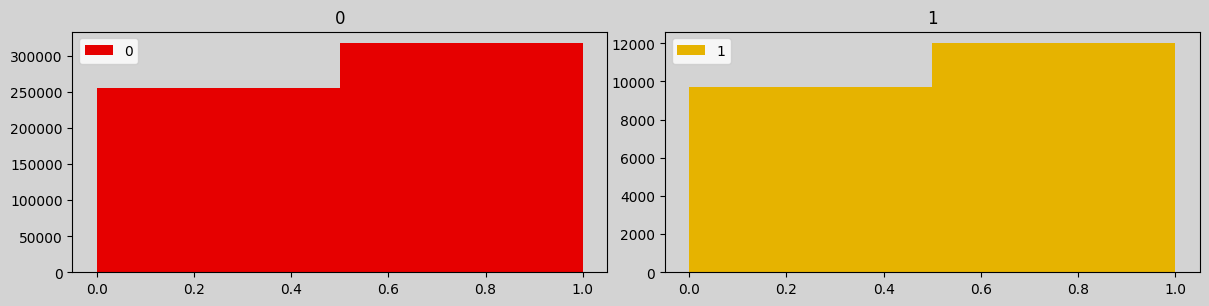

| ps_calc_17_bin ↓ / Target →                   |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          44.580% |          44.625% |           265356 |
| 1                                             |          55.420% |          55.375% |           329856 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_calc_18_bin


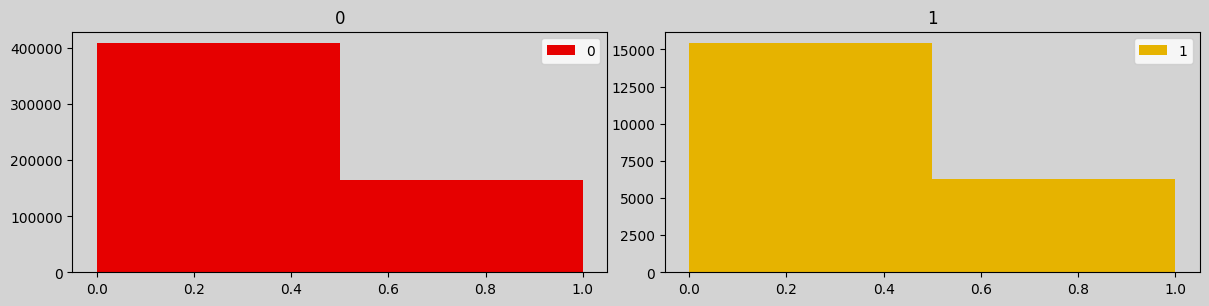

| ps_calc_18_bin ↓ / Target →                   |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          71.287% |          71.153% |           424278 |
| 1                                             |          28.713% |          28.847% |           170934 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_calc_19_bin


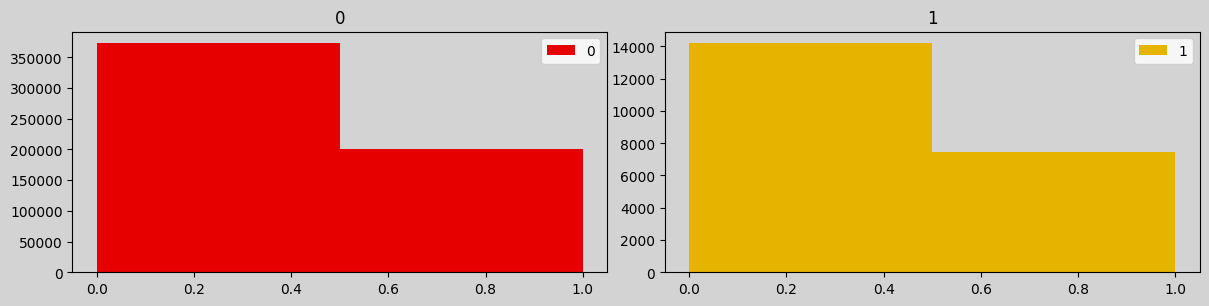

| ps_calc_19_bin ↓ / Target →                   |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          65.081% |          65.525% |           387469 |
| 1                                             |          34.919% |          34.475% |           207743 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |

#### ps_calc_20_bin


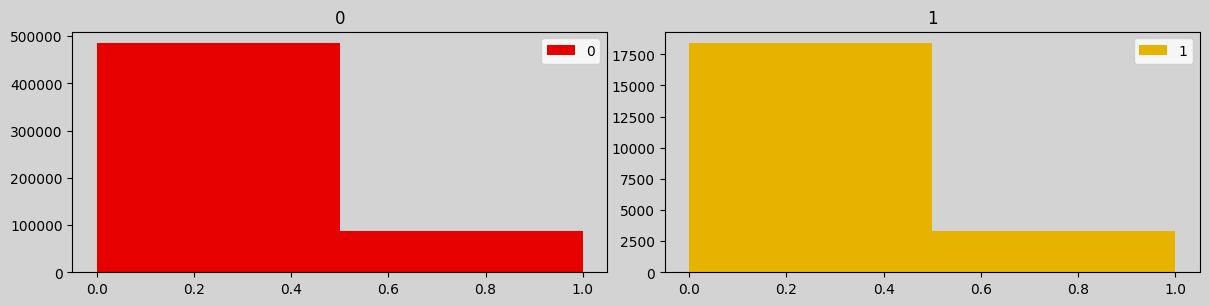

| ps_calc_20_bin ↓ / Target →                   |                0 |                1 |            Total |
| --------------------------------------------- | ---------------- | ---------------- | ---------------- |
| 0                                             |          84.661% |          84.867% |           503955 |
| 1                                             |          15.339% |          15.133% |            91257 |
| -                                             |                - |                - |                - |
| Total                                         |           573518 |            21694 |           595212 |



In [12]:
def print_distr(title, data, col):
    print(f"#### {title}: {col}")

    for k, v in sorted(dict(cl.Counter(data[col])).items(), key=lambda e: e[0]):
        print(f"{k:20}: {v:9}   ({v * 100 / len(data):6.3f}%)")

    print("")


def print_nans(train, test):
    print("#### NaNs")
    print(f"{'Feature':>20} {'Train':>22}   {'Test':>22}")

    for col in test.columns:
        train_nans = np.sum(train[col] == -1)
        test_nans = np.sum(test[col] == -1)

        if train_nans or test_nans:
            train_nans_p = train_nans * 100 / len(train)
            test_nans_p = test_nans * 100 / len(test)
            print(f"{col:>20} {train_nans:9} ({train_nans_p:9.5f}%)   {test_nans:9} ({test_nans_p:9.5f}%)")

    print("")

print_distr("train", train, target_col)
print_distr("rnd_subset", rnd_subset, target_col)
print_nans(train, test)
gen_histograms_and_tables(
    train,
    [col for col in train.columns if col != "id"],
    target_col,
    target_cols,
    with_all=False
)

In [13]:
def clear_nans(data_frame):
    for col in ("ps_reg_03", "ps_car_14", "ps_car_12"):
        data_frame.loc[data_frame[col] == -1, col] += 1

In [14]:
clear_nans(train)
clear_nans(test)
clear_nans(rnd_subset)

In [17]:
class StdCatTransformer(skl.base.BaseEstimator, skl.base.TransformerMixin):
    def __init__(self, col_names=(), standardize=True, bitstring=False):
        self.col_names = col_names
        self.standardize = standardize
        self.bitstring = bitstring
        self._stats = {}
        self._unique_vals = {}
        self._max_vals = {}

    def fit(self, X, y=None, **params):
        self._stats = {}
        self._unique_vals = {}
        self._max_vals = {}

        for idx, col_name in enumerate(self.col_names):
            if col_name.endswith("_bin"):
                continue

            col = X[:, idx]

            if col_name.endswith("_cat"):
                self._unique_vals[col_name] = np.unique(col)
                self._max_vals[col_name] = np.max(np.abs(col))
            elif col_name != "id":
                self._stats[col_name] = (col.mean(), col.std(ddof=1.0))

        return self

    def transform(self, X):
        transformed = []

        for idx, col_name in enumerate(self.col_names):
            col = X[:, idx]

            if col_name == "id" or col_name.endswith("_bin"):
                transformed.append(pd.DataFrame(col, columns=[col_name]))
            elif col_name.endswith("_cat"):
                transformed.extend(self._transform_cat(col, col_name))
            else:
                transformed.append(self._transform_num(col, col_name))

        return pd.concat(transformed, axis=1)

    def _transform_cat(self, col, col_name):
        if self.bitstring:
            return self._transform_cat_bitstring(col, col_name)

        return self._transform_cat_one_hot(col, col_name)

    def _transform_cat_bitstring(self, col, col_name):
        col = col.astype(int)
        transformed = []
        bits = int(np.log2(self._max_vals[col_name]))
        mask = 1 << bits
        bits += 1

        transformed.append(pd.DataFrame((col < 0) * 1, columns=[f"{col_name}_neg"] ))
        col = np.abs(col)

        while bits > 0:
            data_frame = pd.DataFrame(((col & mask) != 0) * 1, columns=[f"{col_name}_{mask}"] )
            transformed.append(data_frame)
            mask >>= 1
            bits -= 1

        return transformed

    def _transform_cat_one_hot(self, col, col_name):
        transformed = []

        for value in sorted(self._unique_vals[col_name]):
            data_frame = pd.DataFrame(
                (col == value) * 1,
                columns=[f"{col_name}_{int(value)}"]
            )

            assert data_frame.isna().sum().sum() == 0, col_name

            transformed.append(data_frame)

        return transformed

    def _transform_num(self, col, col_name):
        if not self.standardize:
            return pd.DataFrame(col, columns=[col_name])

        mean, std = self._stats[col_name]
        data_frame = pd.DataFrame(
            (col - mean) / (std + 0.000001),
            columns=[col_name]
        )

        assert data_frame.isna().sum().sum() == 0, col_name

        return data_frame

def _test_std_cat_transformer():
    raw = pd.DataFrame(
        [
            [1,  2.0, 0, 0.0],
            [2, -3.0, 1, 0.0],
            [3,  7.0, 1, 0.0],
        ],
        columns=["feature_1_cat", "feature_2", "feature_3_bin", "feature_4"]
    )
    expected_std = pd.DataFrame(
        [
            [1, 0, 0,  0.0, 0, 0.0],
            [0, 1, 0, -1.0, 1, 0.0],
            [0, 0, 1,  1.0, 1, 0.0],
        ],
        columns=[
            "feature_1_cat_1",
            "feature_1_cat_2",
            "feature_1_cat_3",
            "feature_2",
            "feature_3_bin",
            "feature_4"
        ]
    )
    expected_no_std = pd.DataFrame(
        [
            [1, 0, 0,  2.0, 0, 0.0],
            [0, 1, 0, -3.0, 1, 0.0],
            [0, 0, 1,  7.0, 1, 0.0],
        ],
        columns=[
            "feature_1_cat_1",
            "feature_1_cat_2",
            "feature_1_cat_3",
            "feature_2",
            "feature_3_bin",
            "feature_4"
        ]
    )

    transformed_std = StdCatTransformer(raw.columns, standardize=True).fit_transform(raw.values)
    transformed_no_std = StdCatTransformer(raw.columns, standardize=False).fit_transform(raw.values)
    abs_diff_std = abs(transformed_std.values - expected_std)
    abs_diff_no_std = abs(transformed_no_std.values - expected_no_std)

    assert all(abs_diff_std.values.flatten() < 0.001), str(transformed) + " (std)"
    assert all(transformed_std.columns == expected_std.columns), str(transformed_std.columns) + " (std)"

    assert all(abs_diff_no_std.values.flatten() < 0.001), str(transformed) + " (no std)"
    assert all(transformed_no_std.columns == expected_no_std.columns), str(transformed_no_std.columns) + " (no std)"


def _test_std_cat_transformer_bitstring():
    raw = pd.DataFrame(
        [
            [ 0, 0.0, 0, 0.0],
            [-1, 0.0, 0, 0.0],
            [ 2, 0.0, 1, 0.0],
            [ 3, 0.0, 0, 0.0],
            [-4, 0.0, 1, 0.0],
            [-5, 0.0, 0, 0.0],
        ],
        columns=["feature_1_cat", "feature_2", "feature_3_bin", "feature_4"]
            )
    expected = pd.DataFrame(
        [
            [0, 0, 0, 0, 0.0, 0, 0.0],
            [1, 0, 0, 1, 0.0, 0, 0.0],
            [0, 0, 1, 0, 0.0, 1, 0.0],
            [0, 0, 1, 1, 0.0, 0, 0.0],
            [1, 1, 0, 0, 0.0, 1, 0.0],
            [1, 1, 0, 1, 0.0, 0, 0.0],
        ],
        columns=[
            "feature_1_cat_neg",
            "feature_1_cat_4",
            "feature_1_cat_2",
            "feature_1_cat_1",
            "feature_2",
            "feature_3_bin",
            "feature_4"
        ]
    )

    transformed = StdCatTransformer(raw.columns, standardize=False, bitstring=True).fit_transform(raw.values)
    abs_diff = abs(transformed.values - expected)

    assert all(abs_diff.values.flatten() < 0.001), str(transformed)
    assert all(transformed.columns == expected.columns), str(transformed.columns)


_test_std_cat_transformer()
_test_std_cat_transformer_bitstring()

In [20]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.dummy import DummyClassifier

from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score
)

from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    #TunedThresholdClassifierCV,
    train_test_split
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

GS_JOBS = 6
CLS_JOBS = 3

RUN_EXPERIMENTS = False


def gini_score(y_true, y_pred):
    """
    From patrick7 at https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
    """

    assert y_true.shape == y_pred.shape, f"Incompatible shapes; {y_true.shape=}, {y_pred.shape=}"
    assert len(y_pred.shape) == 1, f"Expected 1D prediction; {y_pred.shape=}"

    n = len(y_true)
    all_ = np.asarray(np.c_[y_true, y_pred, np.arange(n)], dtype=float)
    all_ = all_[np.lexsort((all_[:, 2], -1 * all_[:, 1]))]
    total_loss = all_[:, 0].sum()
    gini_sum = all_[:, 0].cumsum().sum() / total_loss
    gini_sum -= (n + 1) / 2

    return gini_sum / n


def normalized_gini_score(y_true, y_pred):
    """
    From patrick7 at https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
    """

    def float_eq(a, b):
        return abs(a - b) < 1e-6

    def test(a, b, expected_gs, expected_ngs):
        a = np.array(a)
        b = np.array(b)
        gs = gini_score(a, b)
        ngs = normalized_gini_score(a, b)

        assert float_eq(gs, expected_gs), f"{gs} != {expected_gs} (gini_score)"
        assert float_eq(ngs, expected_ngs), f"{ngs} != {expected_ngs} (normalized_gini_score)"

    test([1, 2, 3], [10, 20, 30], 0.111111, 1)
    test([1, 2, 3], [30, 20, 10], -0.111111, -1)
    test([1, 2, 3], [0, 0, 0], -0.111111, -1)
    test([3, 2, 1], [0, 0, 0], 0.111111, 1)
    test([1, 2, 4, 3], [0, 0, 0, 0], -0.1, -0.8)
    test([2, 1, 4, 3], [0, 0, 2, 1], 0.125, 1)
    test([0, 20, 40, 0, 10], [40, 40, 10, 5, 5], 0, 0)
    test([40, 0, 20, 0, 10], [1000000, 40, 40, 5, 5], 0.171428, 0.6)
    test([40, 20, 10, 0, 0], [40, 20, 10, 0, 0], 0.285714, 1)
    test([1, 1, 0, 1], [0.86, 0.26, 0.52, 0.32], -0.041666, -0.333333)



# The line below was changed to call the `test` function instead of the undefined `_test_gini_score`
#_test_gini_score()
def run_grid_search(classifier, param_grid, tune, resample=None):
    if not RUN_EXPERIMENTS:
        return

    scorings = {
        "F1": "f1",
        "BA": "balanced_accuracy",
        "NG": make_scorer(normalized_gini_score, response_method="predict_proba"),
    }

    with w.catch_warnings():
        w.simplefilter("ignore")

        for scoring_name, scoring in scorings.items():
            try:
                run_grid_search_with_scoring(classifier, param_grid, tune, scoring, scoring_name, resample)

            except Exception as ex:
                print(f"Exception; {scoring_name=}, {type(ex)=}, {str(ex)!r}")


def run_grid_search_with_scoring(classifier, param_grid, tune, scoring, scoring_name, resample):
    experiment = f"{type(classifier).__name__.replace('Classifier', '')} {scoring_name}"
    cv = lambda: StratifiedKFold(n_splits=5, shuffle=True)
    steps = [("trns", StdCatTransformer())]

    param_grid = {
        f"clf__{key}": val for key, val in param_grid.items()
    }
    param_grid.update({"trns__col_names": [rnd_X_train.columns]})

    if resample == "SMOTE":
        steps.append(("smote", SMOTE()))
        param_grid.update({"smote__sampling_strategy": [0.1, 0.3, 0.5]})
    elif resample == "rndover":
        steps.append(("rndover", RandomOverSampler()))
        param_grid.update({"rndover__sampling_strategy": [0.1, 0.3, 0.5]})

    steps.append(("clf", classifier))

    gs = GridSearchCV(
        Pipeline(steps),
        cv=cv(),
        scoring=scoring,
        n_jobs=GS_JOBS,
        param_grid=param_grid,
    )
    gs.fit(rnd_X_train.values, rnd_y_train.values)

    best_model = gs.best_estimator_
    best_params = gs.best_params_
    best_params.pop("trns__col_names")

    print_scores(
        best_model,
        f"{experiment} ",
        rnd_X_train.values,
        rnd_X_test.values,
        rnd_y_train,
        rnd_y_test,
    )
    print(f"  best params: {best_params}")

    #if tune:
    #    tuned_model = TunedThresholdClassifierCV(
    #        best_model,
    #        cv=cv(),
    #        refit=True,
    #        scoring=scoring,
    #        n_jobs=GS_JOBS
    #    )
    #    tuned_model.fit(rnd_X_train.values, rnd_y_train.values)

    #    print_scores(
    #        tuned_model,
    #        f"{experiment} (TUN)",
    #        rnd_X_train.values,
    #        rnd_X_test.values,
    #        rnd_y_train,
    #        rnd_y_test,
    #    )

    print("")


def print_scores(model, title, X_train, X_test, y_train, y_test):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    pred_prob_train = model.predict_proba(X_train)[:, 1]
    pred_prob_test = model.predict_proba(X_test)[:, 1]

    print_scores_pred(title, pred_train, pred_test, pred_prob_train, pred_prob_test, y_train, y_test)


def print_scores_pred(title, pred_train, pred_test, pred_prob_train, pred_prob_test, y_train, y_test):
    pred1_train = np.sum(pred_train == 1) * 100 / len(pred_train)
    pred1_test = np.sum(pred_test == 1) * 100 / len(pred_test)

    ng_train = normalized_gini_score(y_train, pred_prob_train)
    ng_test = normalized_gini_score(y_test, pred_prob_test)

    ba_train = balanced_accuracy_score(y_train, pred_train)
    ba_test = balanced_accuracy_score(y_test, pred_test)

    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)

    prec_train = precision_score(y_train, pred_train)
    prec_test = precision_score(y_test, pred_test)

    rec_train = recall_score(y_train, pred_train)
    rec_test = recall_score(y_test, pred_test)

    print(
        f"{title}  D: {pred1_train:5.1f}% / {pred1_test:5.1f}%   "
        f"NG: {ng_train:.3f} / {ng_test:.3f}   "
        f"BA: {ba_train:.3f} / {ba_test:.3f}   "
        f"F1: {f1_train:.3f} / {f1_test:.3f}   "
        f"P: {prec_train:.3f} / {prec_test:.3f}   "
        f"R: {rec_train:.3f} / {rec_test:.3f}"
    )

In [21]:
run_grid_search(
    KNeighborsClassifier(),
    {
        "n_neighbors": [1, 2, 3, 5, 10, 20, 50],
        "weights": ["uniform", "distance"],
        "n_jobs": [CLS_JOBS],
    },
    tune=True
)

In [22]:
run_grid_search(
    RandomForestClassifier(),
    {
        "max_depth": [2, 3, 5, 7, 10, 15, 20, 50],
        "oob_score": [f1_score, balanced_accuracy_score, normalized_gini_score],
        "class_weight": ["balanced"],
    },
    tune=True,
)

In [23]:
# slow!
#run_grid_search(
#    SVC(),
#    {
#        "C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
#        "gamma": ["scale"],
#        "class_weight": ["balanced"],
#        "probability": [True],
#    },
#    tune=True,
#)

In [24]:
run_grid_search(
    LogisticRegression(),
    {
        "solver": ["saga"],
        "penalty": ["elasticnet"],
        "C": [0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0],
        "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        #"C": [0.01],
        #"l1_ratio": [0.5],
        "class_weight": ["balanced"],
        "max_iter": [3000],
    },
    tune=True,
)

In [25]:
run_grid_search(
    AdaBoostClassifier(),
    {
        "learning_rate": [0.001, 0.01, 0.1, 1.0, 2.0, 10.0],
        "estimator": [
            DecisionTreeClassifier(class_weight="balanced", max_depth=7),
            DecisionTreeClassifier(class_weight="balanced", max_depth=10),
            DecisionTreeClassifier(class_weight="balanced", max_depth=15),
            DecisionTreeClassifier(class_weight="balanced", max_depth=30),
            DecisionTreeClassifier(class_weight="balanced", max_depth=50),
        ],
    },
    tune=True,
)

In [26]:
run_grid_search(
    KNeighborsClassifier(),
    {
        "n_neighbors": [1, 2, 3, 5, 10, 20, 50],
        "weights": ["uniform", "distance"],
        "n_jobs": [CLS_JOBS],
    },
    tune=True,
    resample="SMOTE",
)

In [27]:
run_grid_search(
    RandomForestClassifier(),
    {
        "max_depth": [2, 3, 5, 7, 10, 15, 20, 50],
        "oob_score": [f1_score, balanced_accuracy_score, normalized_gini_score],
        "class_weight": ["balanced"],
    },
    tune=True,
    resample="SMOTE",
)

In [28]:
# slow!
#run_grid_search(
#    SVC(),
#    {
#        "C": [0.05, 0.1, 1.0],
#        "gamma": ["scale"],
#        "class_weight": ["balanced"],
#        "probability": [True],
#    },
#    tune=True,
#    resample="SMOTE",
#)

In [29]:
run_grid_search(
    LogisticRegression(),
    {
        "solver": ["saga"],
        "penalty": ["elasticnet"],
        "C": [0.01, 0.1],
        "l1_ratio": [0.5, 0.9],
        "class_weight": ["balanced"],
        "max_iter": [3000],
    },
    tune=True,
    resample="SMOTE",
)

In [30]:
run_grid_search(
    AdaBoostClassifier(),
    {
        "learning_rate": [0.01, 0.1],
        "estimator": [
            DecisionTreeClassifier(class_weight="balanced", max_depth=7),
            DecisionTreeClassifier(class_weight="balanced", max_depth=10),
            DecisionTreeClassifier(class_weight="balanced", max_depth=15),
            DecisionTreeClassifier(class_weight="balanced", max_depth=30),
            DecisionTreeClassifier(class_weight="balanced", max_depth=50),
        ],
    },
    tune=True,
    resample="SMOTE",
)

In [31]:
run_grid_search(
    KNeighborsClassifier(),
    {
        "n_neighbors": [1, 2, 3, 5, 10, 20, 50],
        "weights": ["uniform", "distance"],
        "n_jobs": [CLS_JOBS],
    },
    tune=True,
    resample="rndover",
)

In [32]:
run_grid_search(
    RandomForestClassifier(),
    {
        "max_depth": [3, 5, 10],
        "oob_score": [f1_score, balanced_accuracy_score, normalized_gini_score],
        "class_weight": ["balanced"],
    },
    tune=True,
    resample="rndover",
)

In [33]:
# slow!
#run_grid_search(
#    SVC(),
#    {
#        "C": [0.05, 0.1, 1.0],
#        "gamma": ["scale"],
#        "class_weight": ["balanced"],
#        "probability": [True],
#    },
#    tune=True,
#    resample="rndover",
#)

In [34]:
run_grid_search(
    LogisticRegression(),
    {
        "solver": ["saga"],
        "penalty": ["elasticnet"],
        "C": [0.01, 0.1],
        "l1_ratio": [0.5, 0.9],
        "class_weight": ["balanced"],
        "max_iter": [3000],
    },
    tune=True,
    resample="rndover",
)

In [35]:
run_grid_search(
    AdaBoostClassifier(),
    {
        "learning_rate": [0.01, 0.1],
        "estimator": [
            DecisionTreeClassifier(class_weight="balanced", max_depth=7),
            DecisionTreeClassifier(class_weight="balanced", max_depth=10),
            DecisionTreeClassifier(class_weight="balanced", max_depth=15),
            DecisionTreeClassifier(class_weight="balanced", max_depth=30),
            DecisionTreeClassifier(class_weight="balanced", max_depth=50),
        ],
    },
    tune=True,
    resample="rndover",
)

In [36]:
def with_tuner(classifier):
    return classifier
    #return TunedThresholdClassifierCV(
    #    classifier,
    #    cv=StratifiedKFold(n_splits=5, shuffle=True),
    #    refit=True,
    #    scoring=make_scorer(normalized_gini_score, response_method="predict_proba"),
    #    n_jobs=2
    #)


def ada_boost_dec_tree():
    return AdaBoostClassifier(
        estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=10),
        learning_rate=0.1,
    )


if RUN_EXPERIMENTS:
    train = pd.read_csv(os.path.join(data_path, "train.csv"))
    test = pd.read_csv(os.path.join(data_path, "test.csv"))

    clear_nans(train)
    clear_nans(test)

    X = train.drop(columns=["id", target_col])
    y = train[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        random_state=4242,
        shuffle=True,
        stratify=y
    )

    rnd_forest = dict(
        oob_score=f1_score,
        max_depth=10,
        class_weight="balanced",
        n_jobs=1,
    )

    log_reg = dict(
        C=0.01,
        class_weight="balanced",
        l1_ratio=0.9,
        max_iter=3000,
        penalty="elasticnet",
        solver="saga",
    )

    stacked = StackingClassifier(
        estimators=[
            ("ab", with_tuner(ada_boost_dec_tree())),
            ("rf", with_tuner(RandomForestClassifier(**rnd_forest))),
            ("lr", with_tuner(LogisticRegression(**log_reg))),
        ],
        final_estimator=LogisticRegression(**log_reg),
        n_jobs=1,
        cv=StratifiedKFold(n_splits=5, shuffle=True),
    )

    voter = VotingClassifier(
        estimators=[
            ("ab", with_tuner(ada_boost_dec_tree())),
            ("rf", with_tuner(RandomForestClassifier(**rnd_forest))),
            ("lr", with_tuner(LogisticRegression(**log_reg))),
        ],
        voting="soft",
        n_jobs=1,
    )

    smpl_strt = 0.5
    rnd_over = RandomOverSampler(sampling_strategy=smpl_strt)
    smote = SMOTE(sampling_strategy=smpl_strt)

    bitstring = True

    for resampler in (rnd_over, smote):
        for classifier in (stacked, voter):
            print(f"{type(resampler)}, {type(classifier)}")

            gc.collect()

            model = Pipeline([
                ("trns", StdCatTransformer(col_names=X_train.columns, bitstring=bitstring)),
                ("resample", resampler),
                ("clf", classifier)
            ])

            model.fit(X_train.values, y_train.values)

            print_scores(model, "", X_train.values, X_test.values, y_train, y_test)

In [37]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")


def print_epoch_loss(epoch, model, device, losses, train_batches, test_batches):
    print(epoch_loss_to_str(epoch, model, device, losses, train_batches, test_batches))


def epoch_loss_to_str(epoch, model, device, losses, train_batches, test_batches):
    now = time.time()
    time_delta = now - losses["begin"]
    losses["begin"] = now

    train_loss = losses["train"][-1]
    test_loss = losses["test"][-1]
    train_loss_min = "..."
    test_loss_min = "..."

    if "train_min" not in losses or train_loss < losses["train_min"]:
        losses["train_min"] = train_loss
        train_loss_min = "MIN"

    if "test_min" not in losses or test_loss < losses["test_min"]:
        losses["test_min"] = test_loss
        test_loss_min = "MIN"

    return (
        f"Epoch {epoch+1:>5}"
        f" {time_delta:>9.3f}s"
        f"   Loss: {train_loss:.6f} / {test_loss:.6f}"
        f" {train_loss_min} / {test_loss_min}"
    )


def train_model(
        model,
        train_loader,
        test_loader,
        loss_fn,
        optimizer,
        device,
        epochs=10,
        before_epoch_fn=lambda epoch, model, device, losses: None,
        after_epoch_fn=print_epoch_loss,
        before_batch_fn=lambda purpose, input_, target: None,
        after_batch_fn=lambda purpose, batch_loss, input_, pred, target: None
):
    losses = {"train": [], "test": [], "begin": 0}

    for epoch in range(epochs):
        losses["begin"] = time.time()
        before_epoch_fn(epoch, model, device, losses)

        model.train(True)
        train_loss, train_batches = run_epoch(
            model,
            train_loader,
            loss_fn,
            before_batch_fn=lambda input_, target: (
                optimizer.zero_grad(),
                before_batch_fn("train", input_, target),
            ),
            after_batch_fn=lambda batch_loss, input_, pred, target: (
                batch_loss.backward(),
                optimizer.step(),
                after_batch_fn("train", batch_loss, input_, pred, target),
            )
        )
        losses["train"].append(train_loss)
        model.train(False)

        with t.no_grad():
            test_loss, test_batches = run_epoch(
                model,
                test_loader,
                loss_fn,
                before_batch_fn=lambda input_, target: before_batch_fn("test", input_, target),
                after_batch_fn=lambda batch_loss, input_, pred, target: after_batch_fn(
                    "test", batch_loss, input_, pred, target
                ),
            )
            losses["test"].append(test_loss)

        after_epoch_fn(epoch, model, device, losses, train_batches, test_batches)

    return losses

def run_epoch(
        model,
        train_loader,
        loss_fn,
        before_batch_fn=lambda input_, target: None,
        after_batch_fn=lambda batch_loss, input_, pred, target: None
):
    loss = 0

    for i, (input_, target) in enumerate(train_loader):
        input_, target = input_.to(device), target.to(device)

        before_batch_fn(input_, target)

        pred = model(input_)
        batch_loss = loss_fn(pred, target)

        loss += batch_loss.item()

        after_batch_fn(batch_loss, input_, pred, target)

    batches = i + 1

    return loss / batches, batches

In [ ]:
train = pd.read_csv(os.path.join(data_path, "train.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))
batch_size = 200

clear_nans(train)
clear_nans(test)

# The dataset is quite big, so we can get away with using
# only a tiny portion for validation.
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(columns=["id", target_col]),
    train[target_col],
    test_size=0.005,
    random_state=4242,
    shuffle=True,
    stratify=train[target_col]
)

transformer = StdCatTransformer(col_names=X_train.columns, bitstring=True)
X_train = transformer.fit_transform(X_train.values, y_train.values)
X_test = transformer.transform(X_test.values)

features = X_train.shape[1]
targets = 1

# Oversampling doesn't seem necessary.
#resampler = RandomOverSampler(sampling_strategy=0.2)
#X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)
X_train_res, y_train_res = X_train, y_train

X_train = t.Tensor(X_train.values).to(t.float32)
y_train = t.Tensor(y_train.values.reshape(y_train.values.shape[0], -1)).to(t.float32)
X_train_res = t.Tensor(X_train_res.values).to(t.float32)
y_train_res = t.Tensor(y_train_res.values.reshape(y_train_res.values.shape[0], -1)).to(t.float32)
X_test = t.Tensor(X_test.values).to(t.float32)
y_test = t.Tensor(y_test.values.reshape(y_test.values.shape[0], -1)).to(t.float32)

train_data_loader = t.utils.data.DataLoader(
    t.utils.data.TensorDataset(X_train_res, y_train_res),
    batch_size=batch_size,
    shuffle=True,
)
test_data_loader = t.utils.data.DataLoader(
    t.utils.data.TensorDataset(X_test, y_test),
    batch_size=batch_size,
)

model = t.nn.Sequential(
    t.nn.Flatten(),
    t.nn.Linear(in_features=features, out_features=256, bias=True),
    t.nn.ReLU(),
    t.nn.Dropout(p=0.3),
    t.nn.BatchNorm1d(num_features=256),
    t.nn.Linear(in_features=256, out_features=256, bias=True),
    t.nn.ReLU(),
    t.nn.Dropout(p=0.3),
    t.nn.BatchNorm1d(num_features=256),
    t.nn.Linear(in_features=256, out_features=128, bias=True),
    t.nn.ReLU(),
    t.nn.Dropout(p=0.3),
    t.nn.BatchNorm1d(num_features=128),
    t.nn.Linear(in_features=128, out_features=128, bias=True),
    t.nn.ReLU(),
    t.nn.Dropout(p=0.3),
    t.nn.BatchNorm1d(num_features=128),
    t.nn.Linear(in_features=128, out_features=64, bias=True),
    t.nn.ReLU(),
    t.nn.Dropout(p=0.3),
    t.nn.BatchNorm1d(num_features=64),
    t.nn.Linear(in_features=64, out_features=32, bias=True),
    t.nn.ReLU(),
    t.nn.Dropout(p=0.3),
    t.nn.BatchNorm1d(num_features=32),
    t.nn.Linear(in_features=32, out_features=targets, bias=True),
    # This is merged into the loss function;
    # but don't forget to apply it to the prediction!
    #t.nn.Sigmoid(),
).to(device, dtype=t.float32)
opt = t.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

loss_fn = t.nn.BCEWithLogitsLoss()

losses = train_model(model, train_data_loader, test_data_loader, loss_fn, opt, device, epochs=110)

Epoch     1    39.994s   Loss: 0.217330 / 0.156712 MIN / MIN
Epoch     2    40.159s   Loss: 0.160932 / 0.156150 MIN / MIN
Epoch     3    42.332s   Loss: 0.158573 / 0.155774 MIN / MIN
Epoch     4    41.620s   Loss: 0.157561 / 0.155185 MIN / MIN
Epoch     5    40.506s   Loss: 0.156706 / 0.154873 MIN / MIN
Epoch     6    40.019s   Loss: 0.156307 / 0.154512 MIN / MIN


In [ ]:
model.train(False)

with t.no_grad():
    pred_prob_train = t.nn.functional.sigmoid(model(X_train.to(device))).cpu().numpy()
    pred_prob_test = t.nn.functional.sigmoid(model(X_test.to(device))).cpu().numpy()


# Find a threshold value based on the training data. This won't
# actually affect the Gini score, it's just for the diagnostic
# log message.
pos_ratio = (np.sum(y_train.cpu().numpy() == 1) / len(y_train))
threshold = np.percentile(pred_prob_train, 100.0 - pos_ratio * 100.0)
print(f"{threshold=:.5f}")

pred_train = (pred_prob_train > threshold) * 1
pred_test = (pred_prob_test > threshold) * 1

print_scores_pred(
    "",
    pred_train.flatten(),
    pred_test.flatten(),
    pred_prob_train.flatten(),
    pred_prob_test.flatten(),
    y_train.cpu().numpy().flatten(),
    y_test.cpu().numpy().flatten(),
)

# Charts.

ax = plt.subplots(1, 2, figsize=(9, 3))[1]

ax[0].hist(
    [
        pred_prob_train[pred_prob_train <= threshold],
        pred_prob_train[pred_prob_train > threshold]
    ],
    bins=200,
    stacked=True
)
ax[0].set_title("Predictions (train)")
ax[1].hist(
    [
        pred_prob_test[pred_prob_test <= threshold],
        pred_prob_test[pred_prob_test > threshold]
    ],
    bins=200,
    stacked=True
)
ax[1].set_title("Predictions (test)")
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(losses["train"][5:], label="train")
plt.plot(losses["test"][5:], label="test")
plt.legend()
plt.title("Training losses (after the 5th epoch)")
plt.show()

In [ ]:
sub = pd.read_csv(os.path.join(data_path, "sample_submission.csv"), index_col="id")

X_sub = test.drop(columns=["id"])
X_sub = transformer.transform(X_sub.values)
X_sub = t.Tensor(X_sub.values).to(t.float32)

model.train(False)

with t.no_grad():
    pred_prob_sub = t.nn.functional.sigmoid(model(X_sub.to(device))).cpu().numpy()

pred_prob_sub = pred_prob_sub.flatten()

sub[target_col] = pred_prob_sub

sub.to_csv("submission.csv")
sub.head()